<a href="https://colab.research.google.com/github/pyagoubi/Stuff/blob/main/municipalities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [54]:
import pandas as pd
import seaborn as sns
import math
import numpy as np
import matplotlib as plt
from sklearn.linear_model import LinearRegression

Preprocessing and Data Cleaning

In [21]:
file_names = ['bakery', 'bar', 'education', 'grocery', 'kiosk', 'public_park', 'post', 'restaurant',
              'veloparking', 'pharmacy', 'public_park']  # replace with your actual list of file names
column_to_check = 'Address'
word_to_check = 'switzerland'

dropped_rows_df = pd.DataFrame()  # DataFrame to collect all dropped rows
total_length_after_drop = 0

for file_name in file_names:
    df = pd.read_excel(f"/content/drive/MyDrive/mun/data/{file_name}.xlsx")  # load Excel data into DataFrame

    #print(f"Length of {file_name} DataFrame before dropping rows: {len(df)}")

    mask = df[column_to_check].str.contains(word_to_check, case=False, na=False)

    # Collect the dropped rows
    dropped_rows = df[~mask]
    dropped_rows_df = pd.concat([dropped_rows_df, dropped_rows])

    # Drop rows where word is not found in the column
    df = df[mask]

    #print(f"Length of {file_name} DataFrame after dropping rows: {len(df)}")
    total_length_after_drop += len(df)

    # Create a separate variable for each DataFrame
    exec(f"{file_name}_df = df")

    df.to_excel(f"/content/drive/MyDrive/mun/data/clean/{file_name}_clean.xlsx")

# dropped_rows_df contains all rows dropped from all DataFrames.
print(f"Total length of all cleaned datasets combined: {total_length_after_drop}")


Total length of all cleaned datasets combined: 481520


In [22]:
muns = pd.read_excel('/content/drive/MyDrive/mun/data/municipalities.xlsx')
muns.rename(columns={muns.columns[0]: "municipality"}, inplace=True)

In [23]:
for file_name in file_names:
    # Retrieve the DataFrame from the variable
    df = eval(f"{file_name}_df")

    # Rename the first column
    df.rename(columns={df.columns[0]: "municipality"}, inplace=True)

    # Update the variable with the renamed DataFrame
    exec(f"{file_name}_df = df")

In [24]:
for file_name in file_names:
    # Retrieve the DataFrame from the variable
    df = eval(f"{file_name}_df")

    # Count the occurrence of each municipality in the DataFrame
    count = df['municipality'].value_counts()

    # Create a new column in the municipalities DataFrame
    # For each municipality in the municipalities DataFrame,
    # the value in the new column is the count of the municipality in the current DataFrame
    # If a municipality does not exist in the current DataFrame, the value is 0
    muns[file_name] = muns['municipality'].map(count).fillna(0)

In [41]:
adj = pd.read_excel('/content/drive/MyDrive/mun/data/adjustments.xlsx')
adj.rename(columns={adj.columns[0]: "municipality"}, inplace=True)

Manual Adjustments

In [44]:
# set 'municipality' as index for easy replacement
#muns.reset_index(inplace=True)

muns.set_index('municipality', inplace=True)
adj.set_index('municipality', inplace=True)

# update the values
muns.update(adj)

# reset the index
muns.reset_index(inplace=True)
adj.reset_index(inplace=True)

Calcuate Density

In [46]:
for file_name in file_names:
    muns[file_name] = muns[file_name].div(muns['Area'])

In [48]:
muns['population_density']  = muns['Residents'].div(muns['Area'])

In [51]:
commercial = ['bakery', 'bar', 'grocery', 'restaurant', 'kiosk', 'pharmacy']
public = ['education', 'post', 'veloparking', 'public_park' ]

# Create a new column for each list and set its values to the mean of the columns specified in the respective list
muns['commercial'] = muns[commercial].mean(axis=1)
muns['public'] = muns[public].mean(axis=1)

##Get alpha values for each service – scatterplots


###- First set of scatterplots: data cummulative for the whole country for each service + summary of the exponents (the alphas for each service)

In [56]:
import matplotlib.pyplot as plt

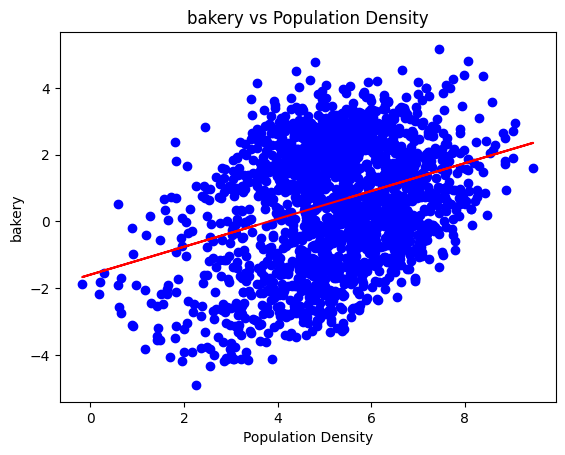

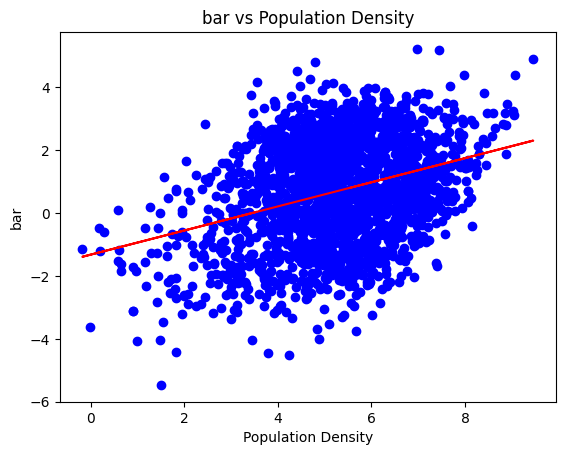

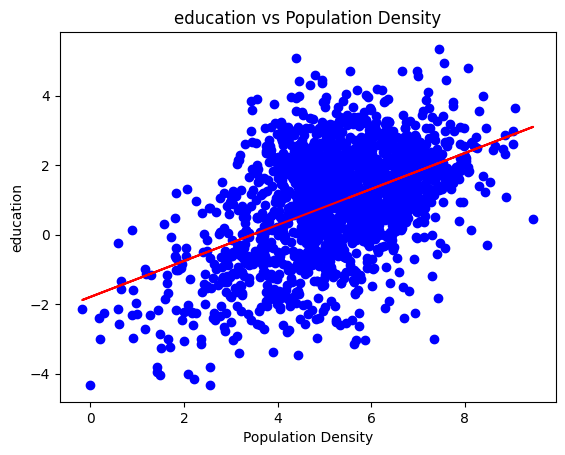

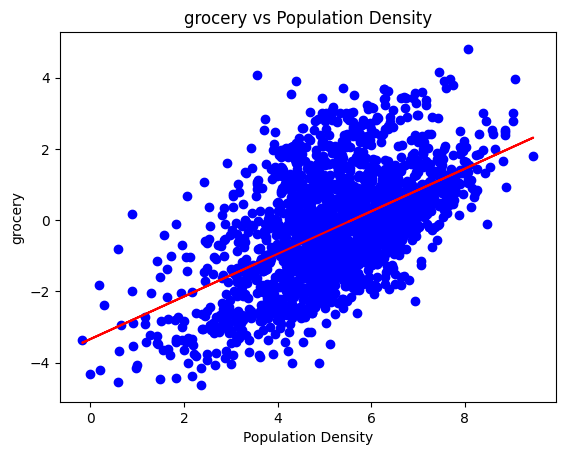

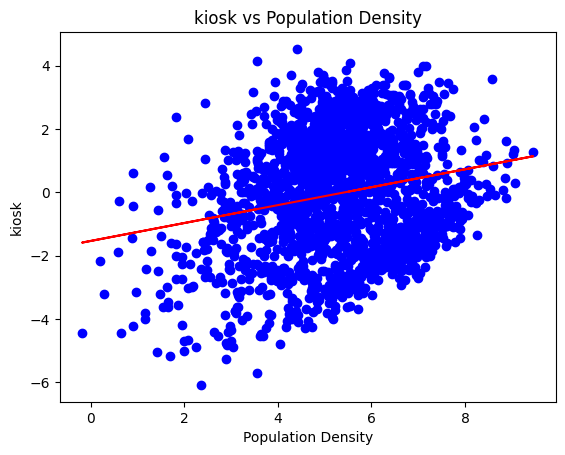

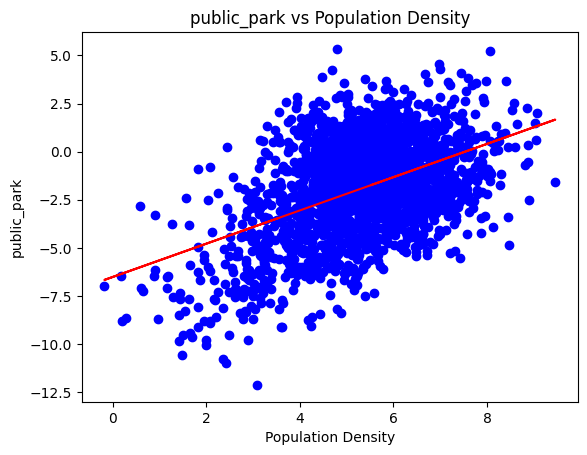

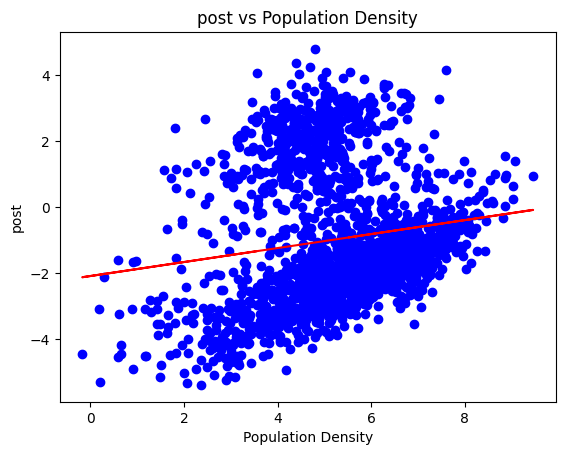

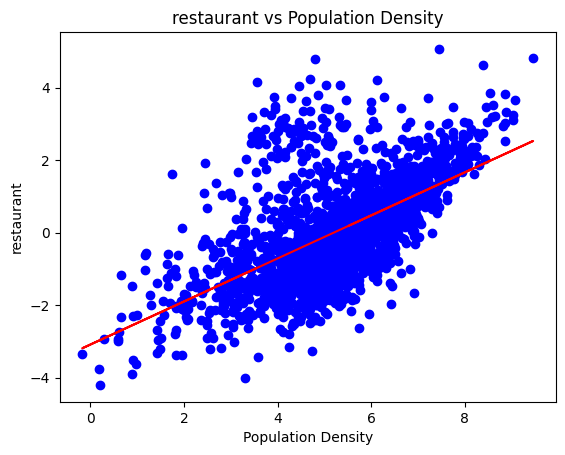

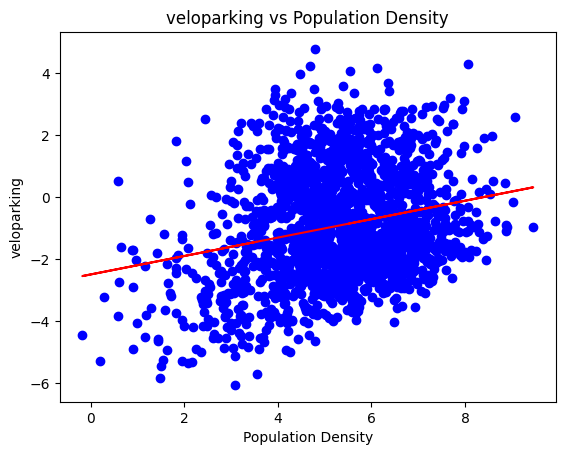

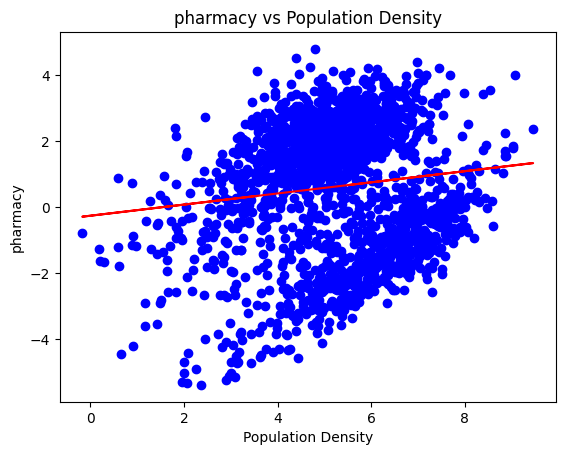

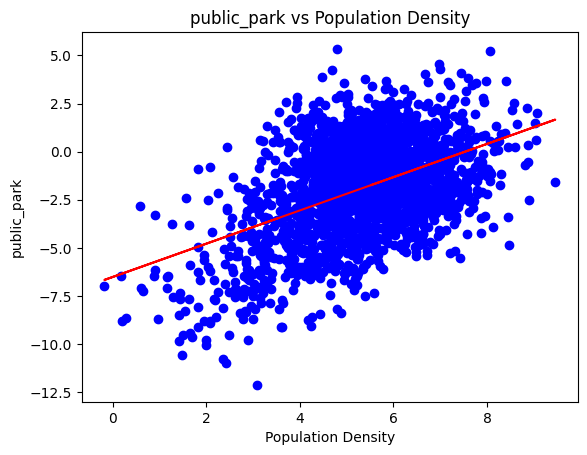

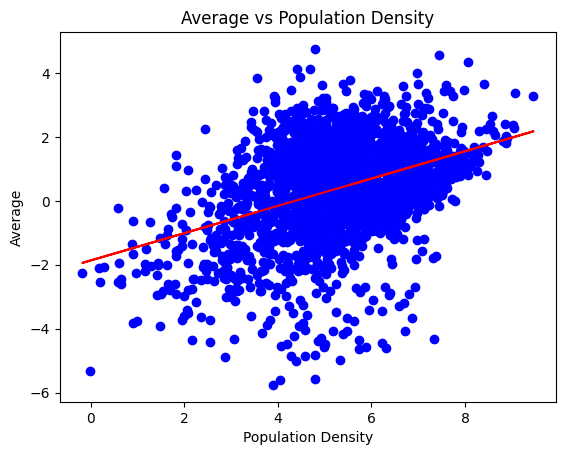

Slope Coefficient
bakery                0.417674
bar                   0.383366
education             0.517125
grocery               0.597539
kiosk                 0.282890
public_park           0.865043
post                  0.211730
restaurant            0.593857
veloparking           0.297619
pharmacy              0.168601
average               0.427063

In [59]:
# Initialize a dictionary to store the slope coefficients
coefficients = {}

# Loop over the file names
for file_name in file_names:
    # Remove rows with zeros to avoid issues with log transformation
    data = muns[muns[file_name] != 0]
    data = data[data['population_density'] != 0]

    # Log transform the data
    log_data = np.log(data[[file_name, 'population_density']])

    # Prepare the data for linear regression
    X = log_data['population_density'].values.reshape(-1, 1)
    y = log_data[file_name].values.reshape(-1, 1)

    # Perform linear regression
    model = LinearRegression().fit(X, y)

    # Store the slope coefficient in the dictionary
    coefficients[file_name] = model.coef_[0][0]

    # Plot the scatterplot and regression line
    plt.scatter(X, y, color='blue')
    plt.plot(X, model.predict(X), color='red')
    plt.xlabel('Population Density')
    plt.ylabel(file_name)
    plt.title(f'{file_name} vs Population Density')
    plt.show()

# Compute the average of all variable names, log-transform it, and run a linear regression
muns['average'] = muns[file_names].mean(axis=1)
data_avg = muns[muns['average'] != 0]
data_avg = data_avg[data_avg['population_density'] != 0]
log_data_avg = np.log(data_avg[['average', 'population_density']])
X_avg = log_data_avg['population_density'].values.reshape(-1, 1)
y_avg = log_data_avg['average'].values.reshape(-1, 1)
model_avg = LinearRegression().fit(X_avg, y_avg)
coefficients['average'] = model_avg.coef_[0][0]

# Plot the scatterplot and regression line
plt.scatter(X_avg, y_avg, color='blue')
plt.plot(X_avg, model_avg.predict(X_avg), color='red')
plt.xlabel('Population Density')
plt.ylabel('Average')
plt.title('Average vs Population Density')
plt.show()

# Convert the dictionary to a DataFrame and display it
coefficients_df = pd.DataFrame.from_dict(coefficients, orient='index', columns=['Slope Coefficient'])
coefficients_df

### second set of scatterplots: 3 categories (urban rural intermediate) so, each service x3

In [75]:
muns.rename(columns={muns.columns[1]: 'typology'}, inplace=True)

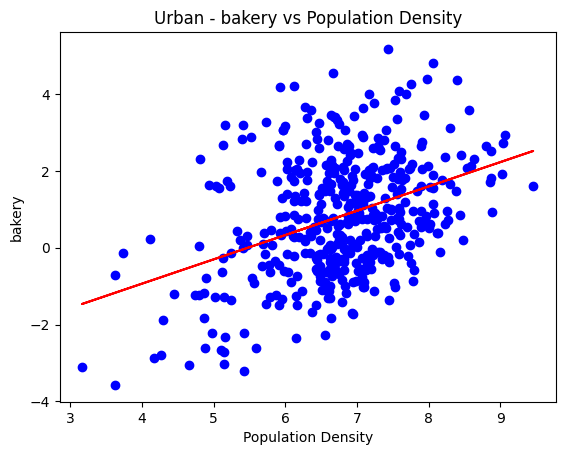

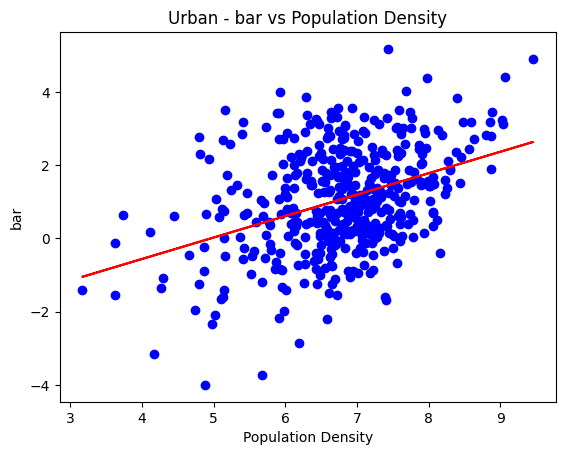

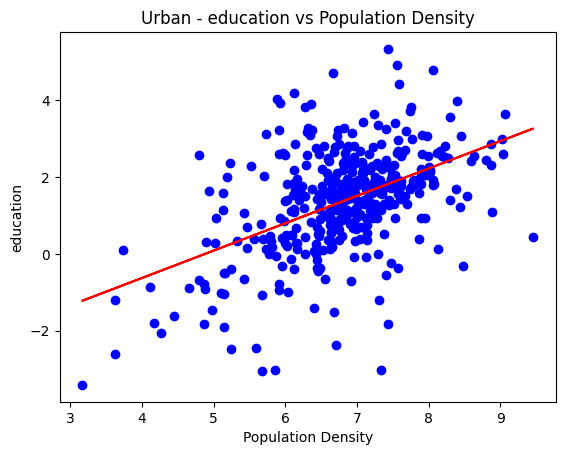

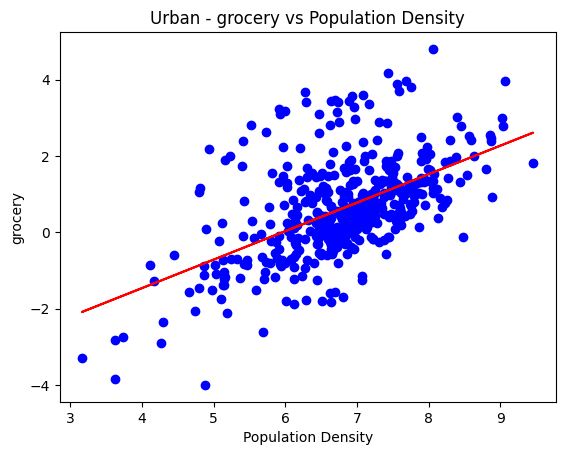

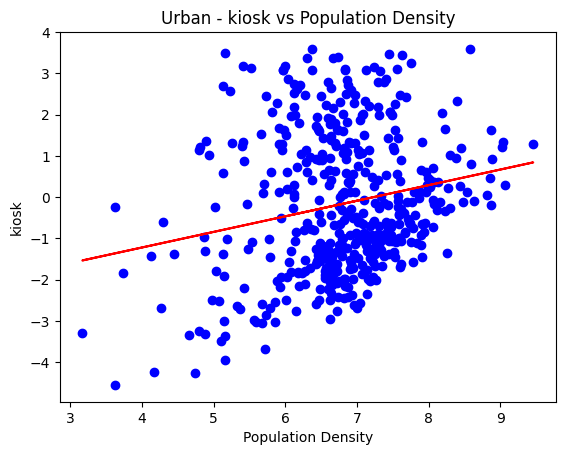

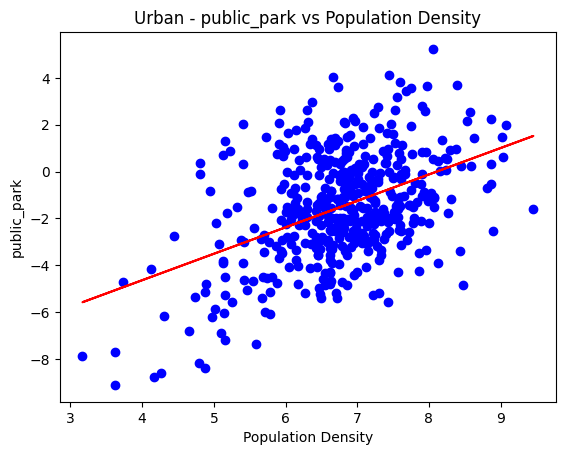

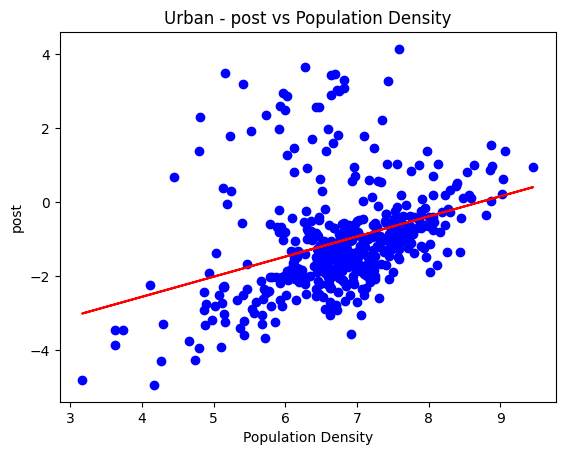

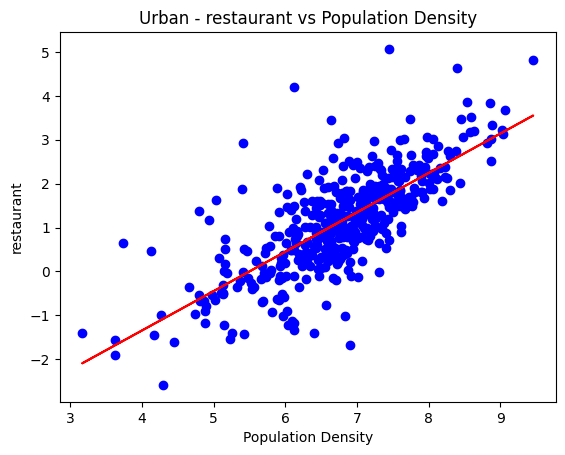

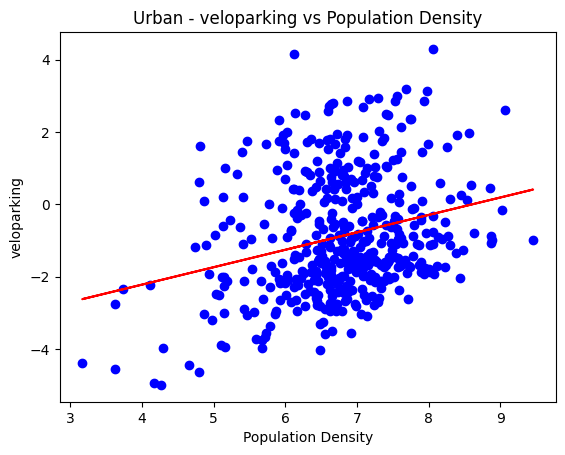

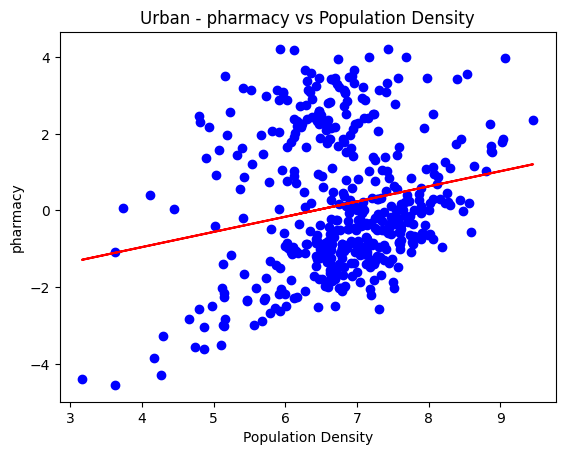

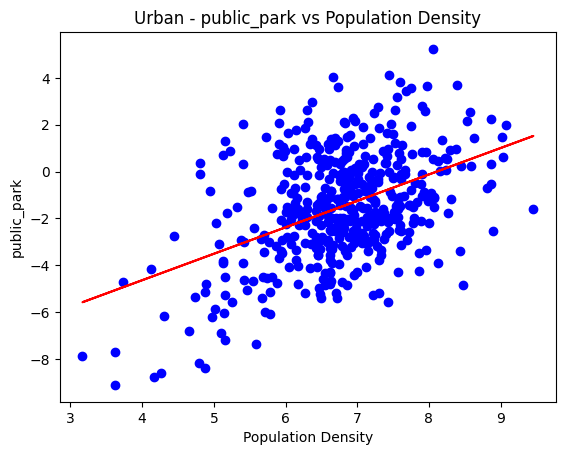

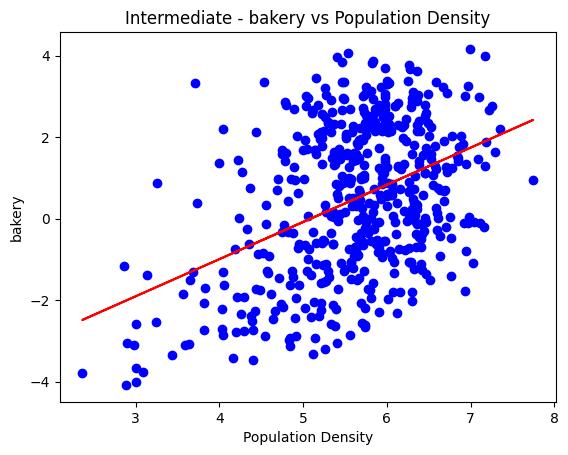

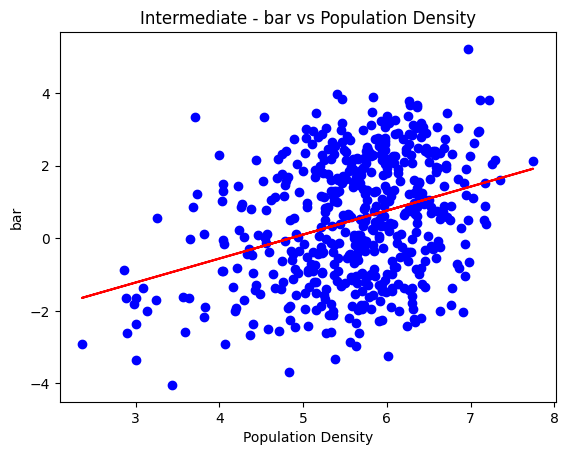

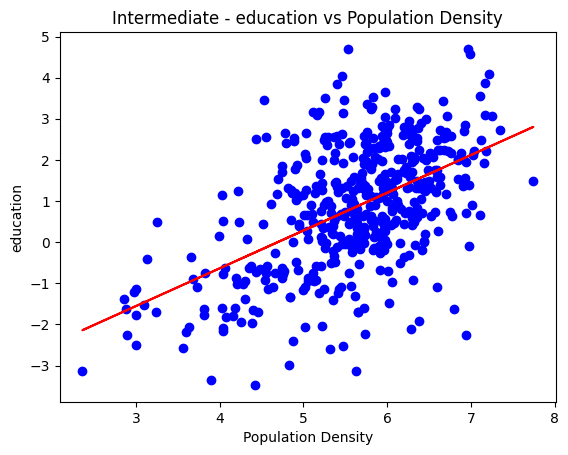

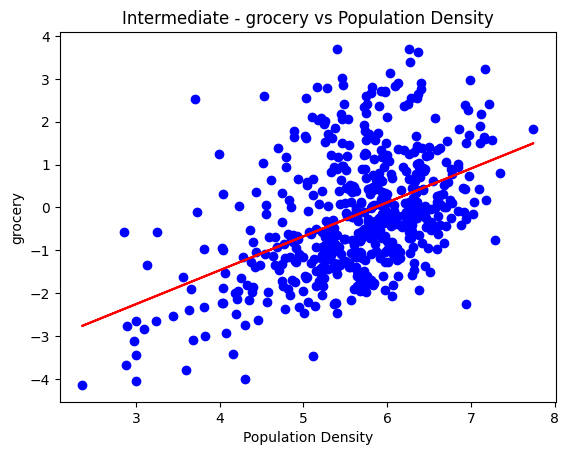

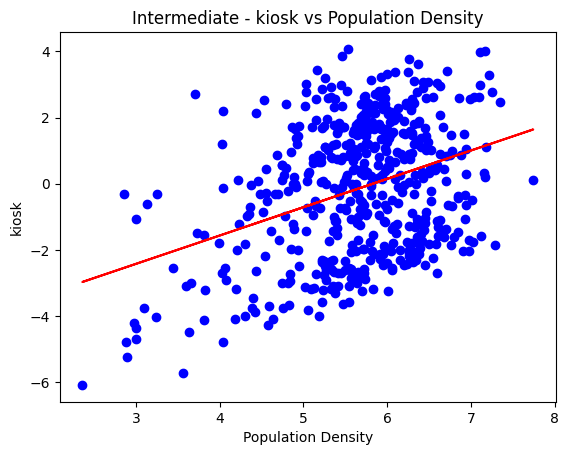

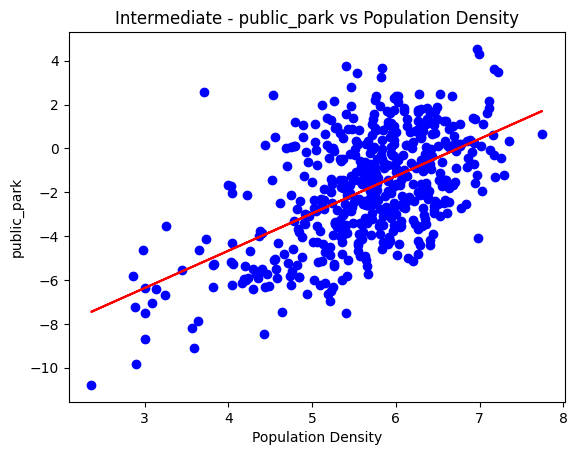

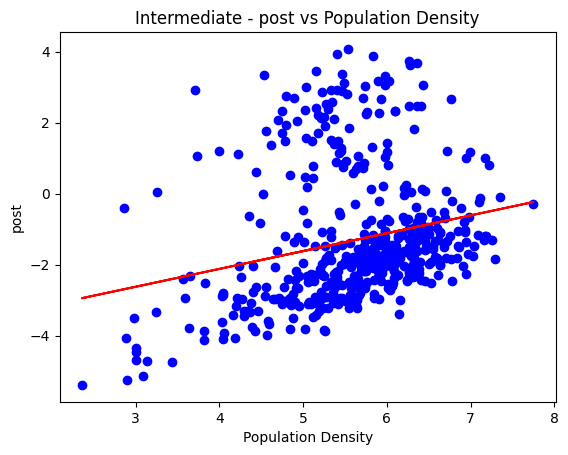

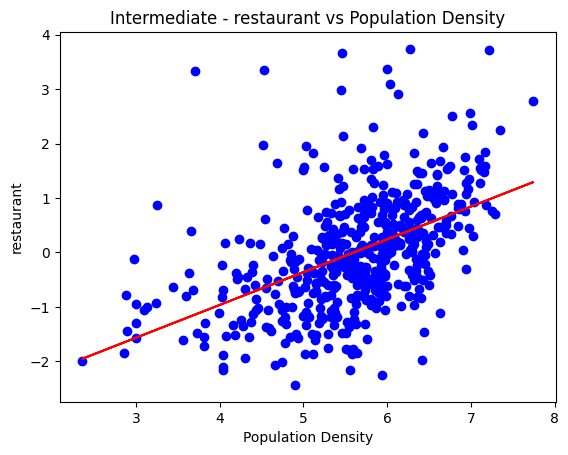

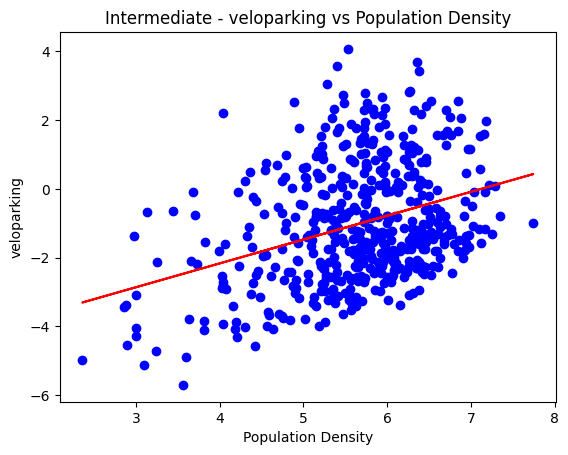

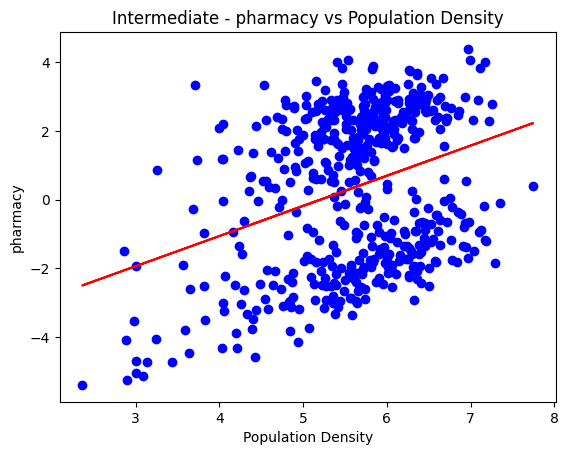

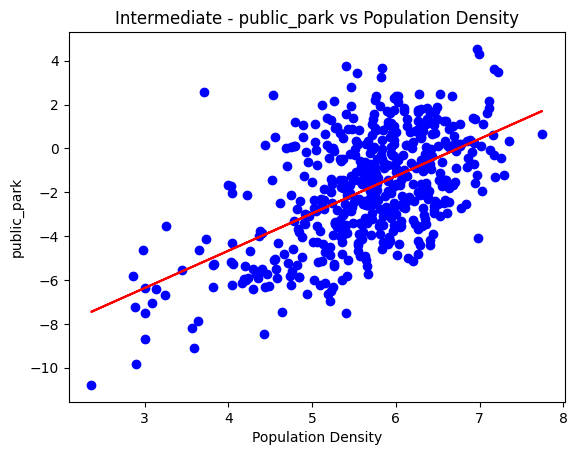

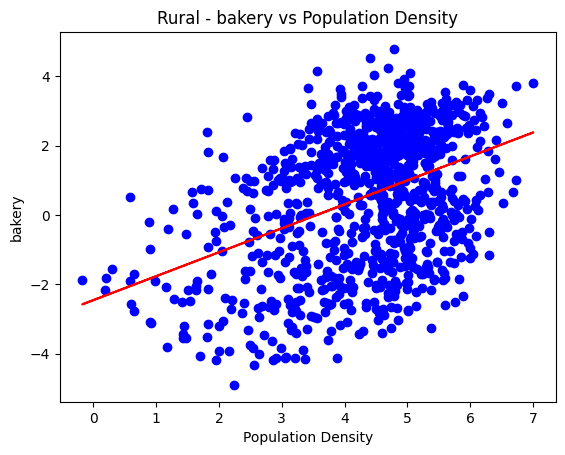

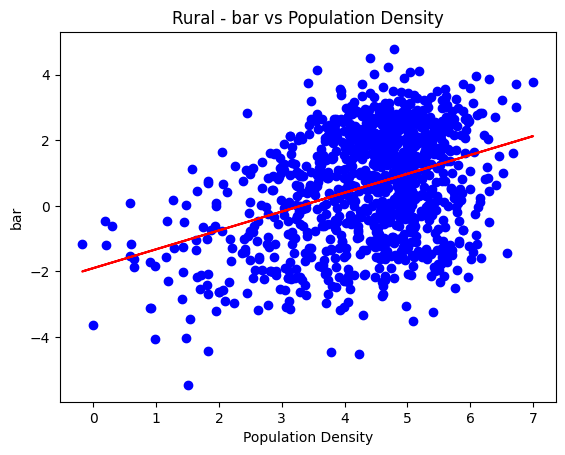

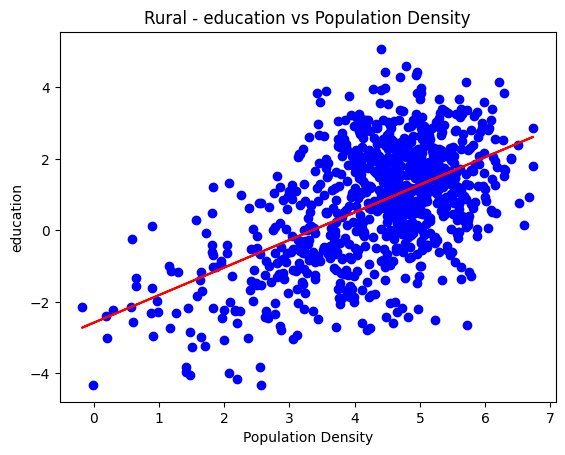

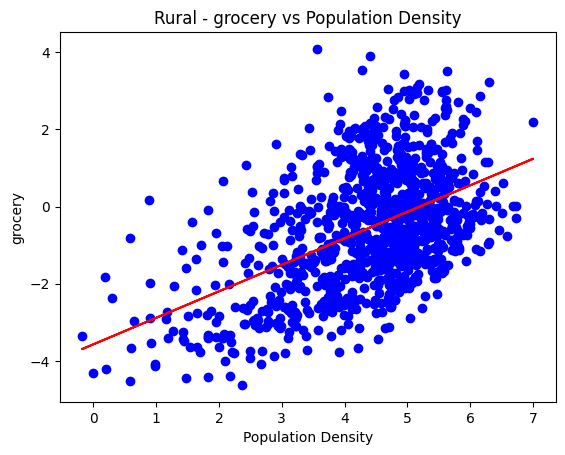

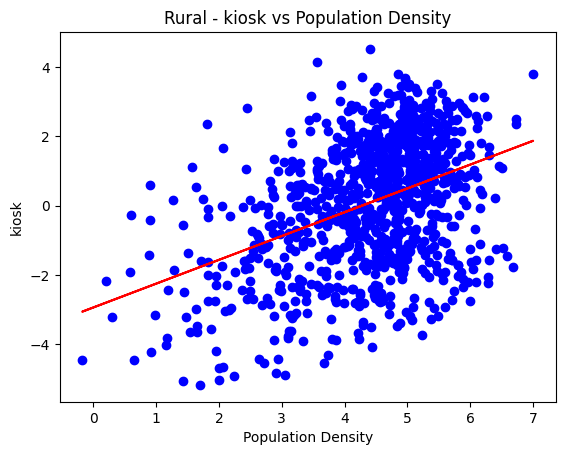

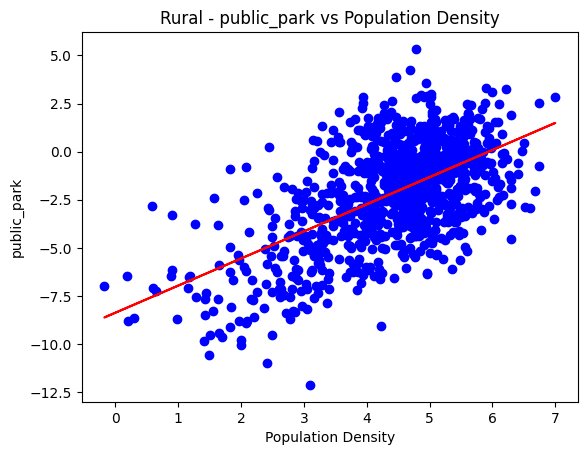

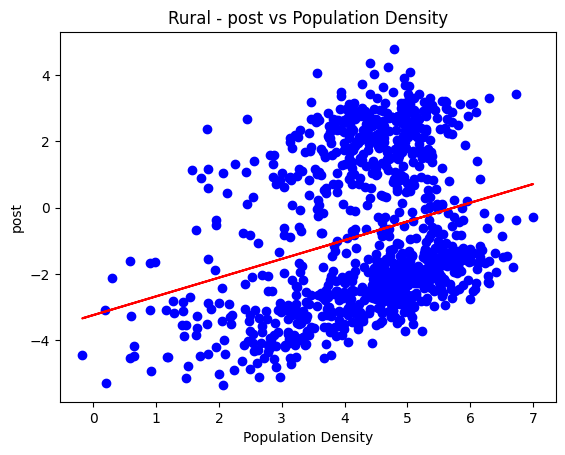

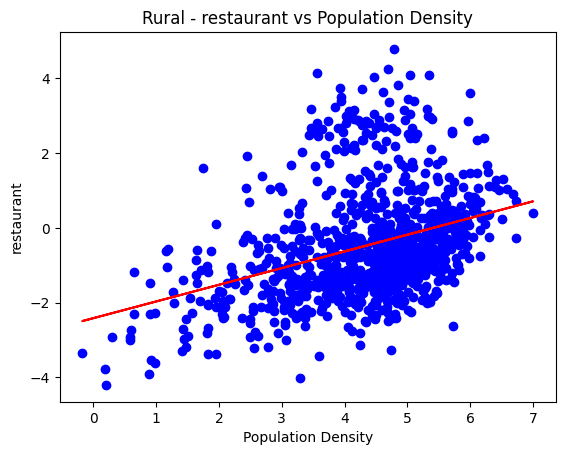

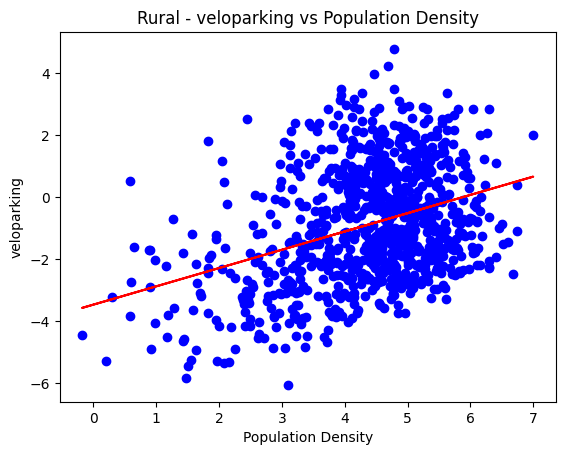

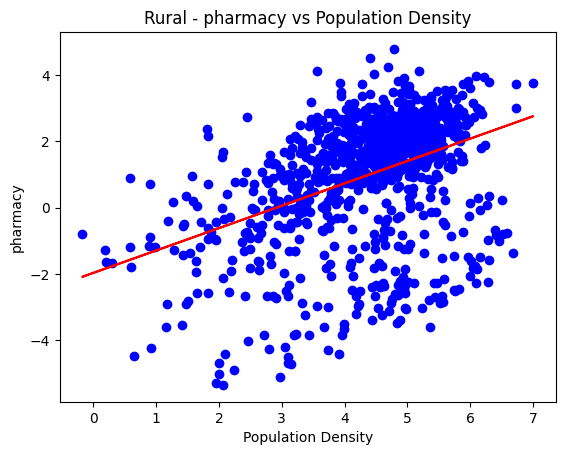

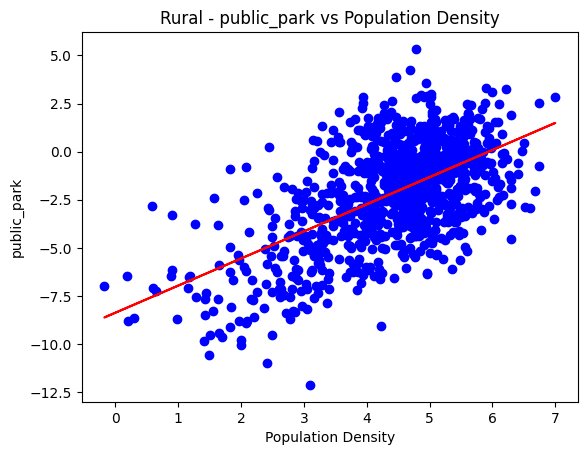

Slope Coefficient
Urban_bakery                       0.632725
Urban_bar                          0.585709
Urban_education                    0.713520
Urban_grocery                      0.747076
Urban_kiosk                        0.377950
Urban_public_park                  1.127821
Urban_post                         0.543138
Urban_restaurant                   0.897368
Urban_veloparking                  0.481976
Urban_pharmacy                     0.395965
Intermediate_bakery                0.912066
Intermediate_bar                   0.660316
Intermediate_education             0.918069
Intermediate_grocery               0.790408
Intermediate_kiosk                 0.856592
Intermediate_public_park           1.700388
Intermediate_post                  0.502510
Intermediate_restaurant            0.602211
Intermediate_veloparking           0.694555
Intermediate_pharmacy              0.877781
Rural_bakery                       0.690588
Rural_bar                          0.575544
Rural_education                    0.771808
Rural_grocery                      0.687172
Rural_kiosk                        0.686926
Rural_public_park                  1.408972
Rural_post                         0.564520
Rural_restaurant                   0.446673
Rural_veloparking                  0.590468
Rural_pharmacy                     0.674932

In [77]:
# Define typology labels
typology_labels = {1: 'Urban', 2: 'Intermediate', 3: 'Rural'}

# Initialize a dictionary to store the slope coefficients
coefficients = {}

# Loop over the typology labels
for typology, label in typology_labels.items():

    # Filter DataFrame based on typology
    filtered_muns = muns[muns['typology'] == typology]

    # Loop over the file names
    for file_name in file_names:
        # Remove rows with zeros to avoid issues with log transformation
        data = filtered_muns[filtered_muns[file_name] != 0]
        data = data[data['population_density'] != 0]

        # Log transform the data
        log_data = np.log(data[[file_name, 'population_density']])

        # Prepare the data for linear regression
        X = log_data['population_density'].values.reshape(-1, 1)
        y = log_data[file_name].values.reshape(-1, 1)

        # Perform linear regression
        model = LinearRegression().fit(X, y)

        # Store the slope coefficient in the dictionary
        coefficients[f'{label}_{file_name}'] = model.coef_[0][0]

        # Plot the scatterplot and regression line
        plt.scatter(X, y, color='blue')
        plt.plot(X, model.predict(X), color='red')
        plt.xlabel('Population Density')
        plt.ylabel(file_name)
        plt.title(f'{label} - {file_name} vs Population Density')
        plt.show()

# Convert the dictionary to a DataFrame and display it
coefficients_df = pd.DataFrame.from_dict(coefficients, orient='index', columns=['Slope Coefficient'])
coefficients_df

###- thirdset of scatterplots: 9 categories, so each service x9 ( a lot of scatterplots)

In [ ]:
pd.set_option('display.max_rows', None)

In [82]:
gemeinde = pd.read_excel('/content/drive/MyDrive/mun/data/mapping_gemeinde.xlsx')

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


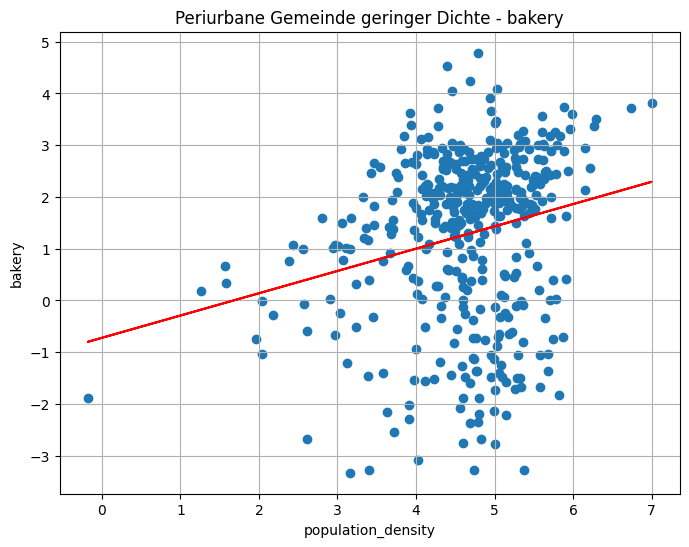

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


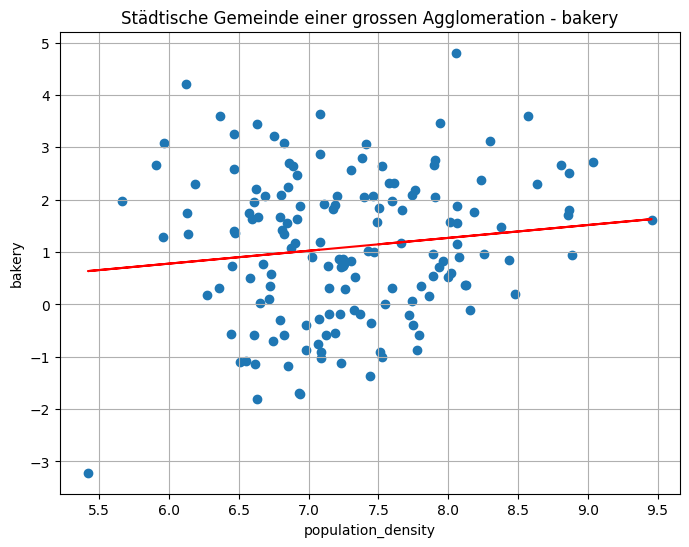

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


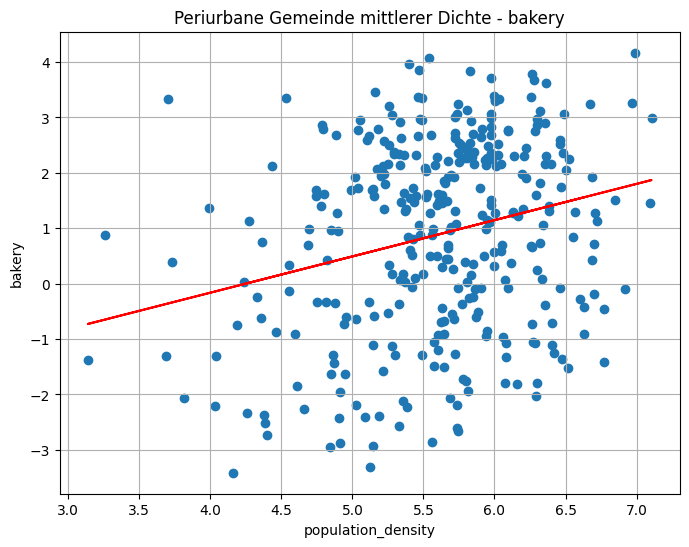

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


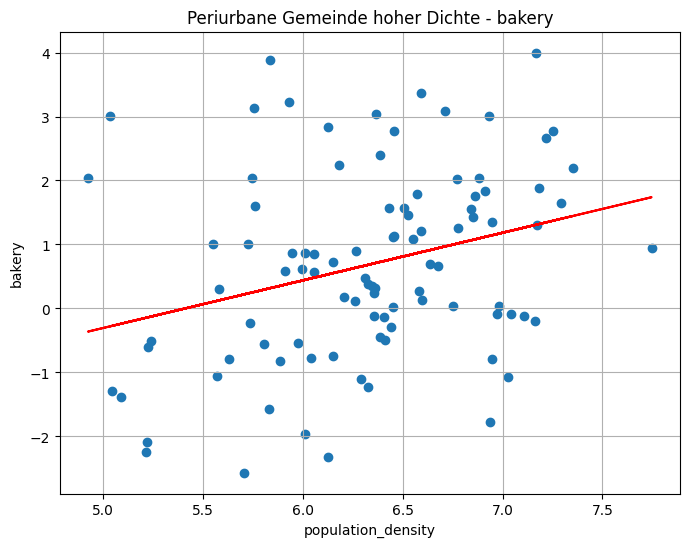

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


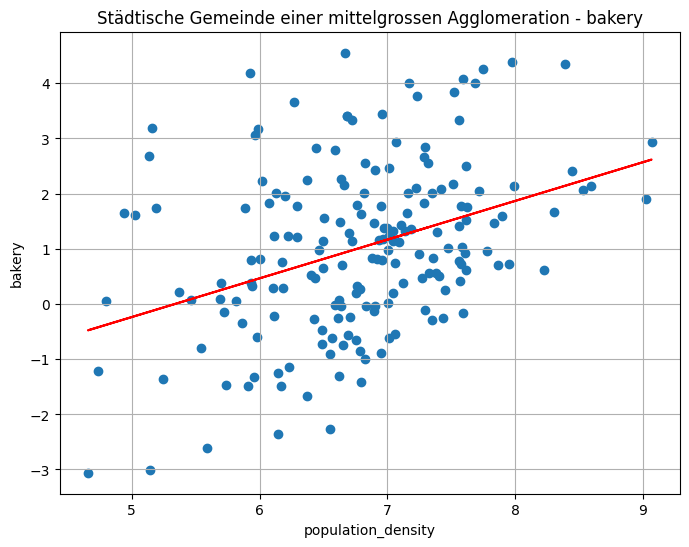

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


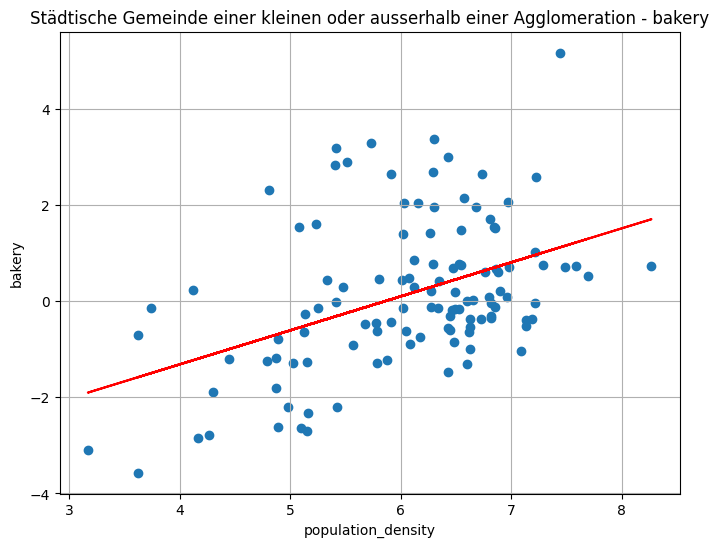

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


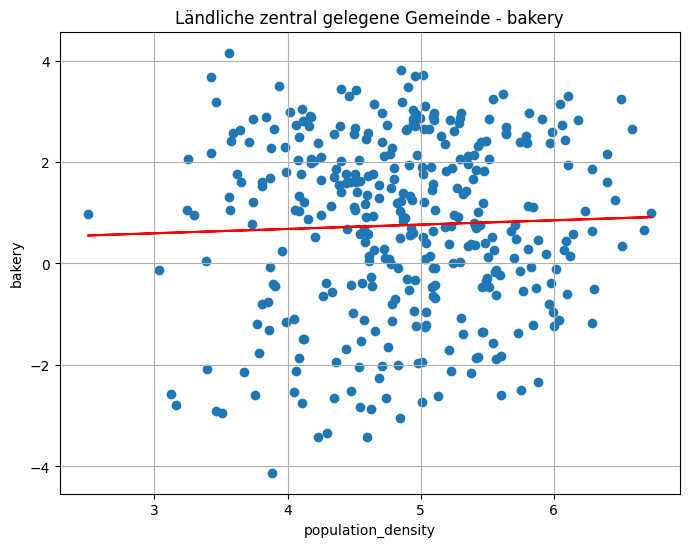

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


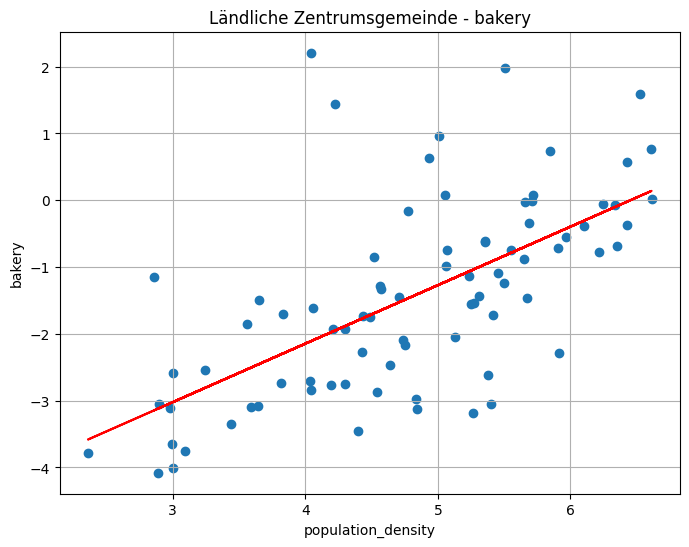

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


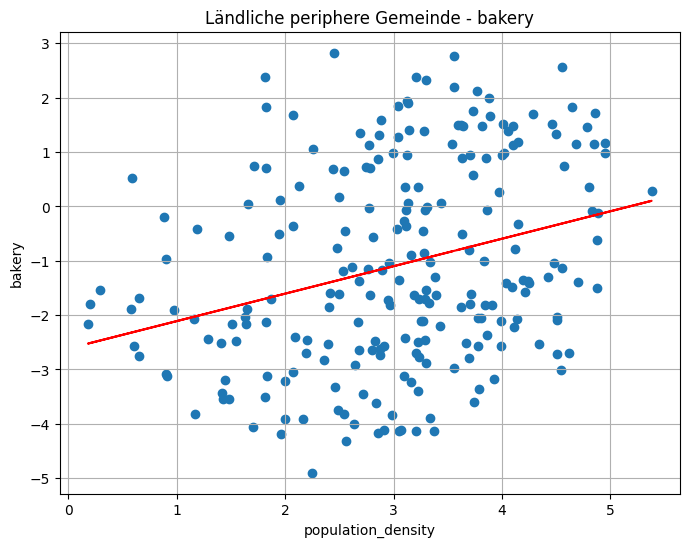

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


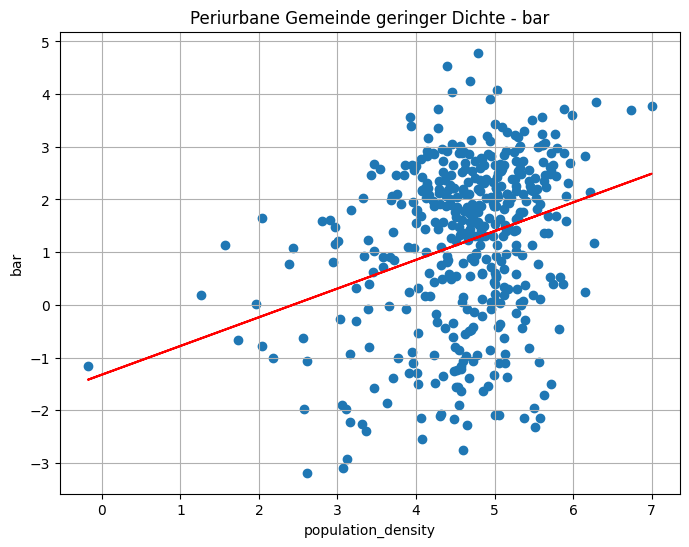

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


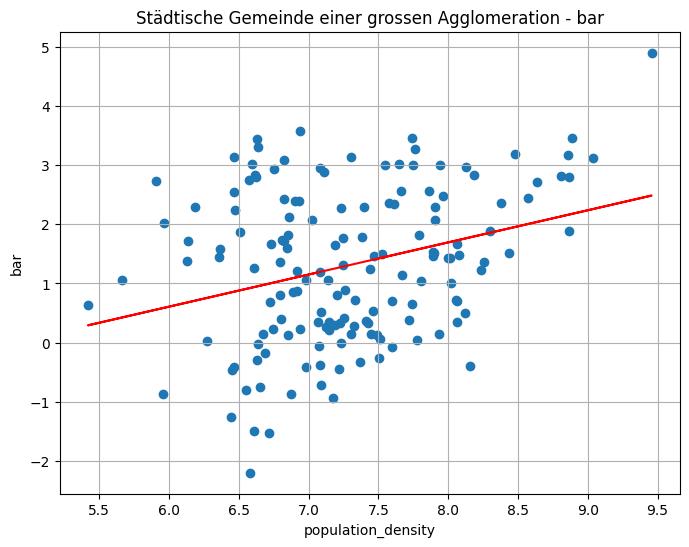

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


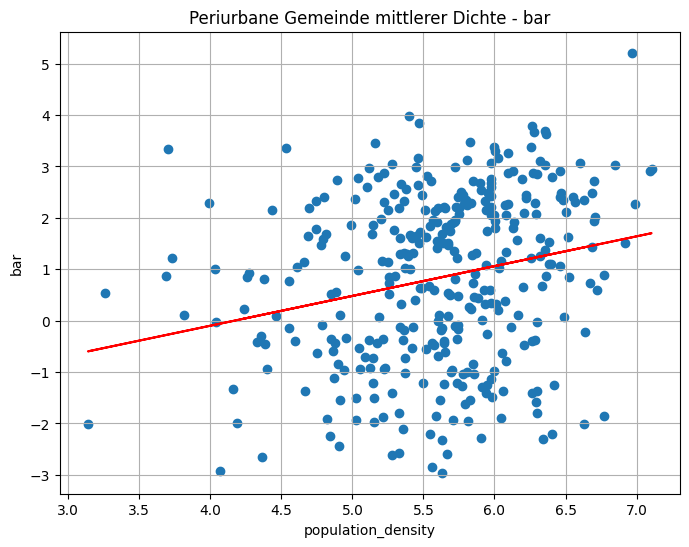

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


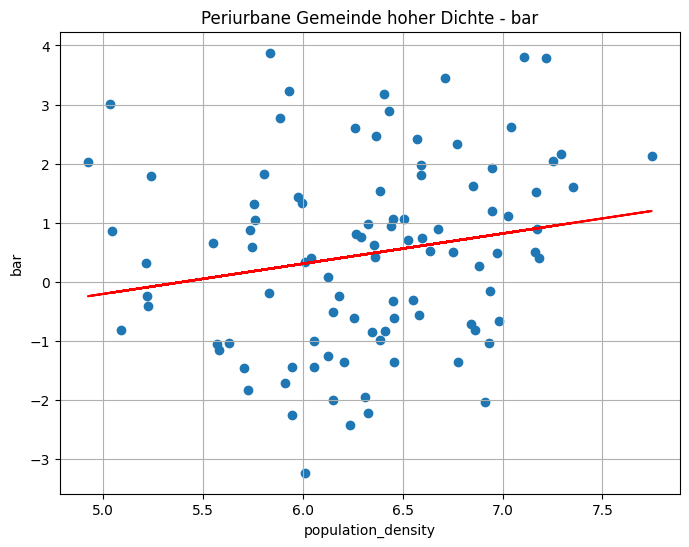

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


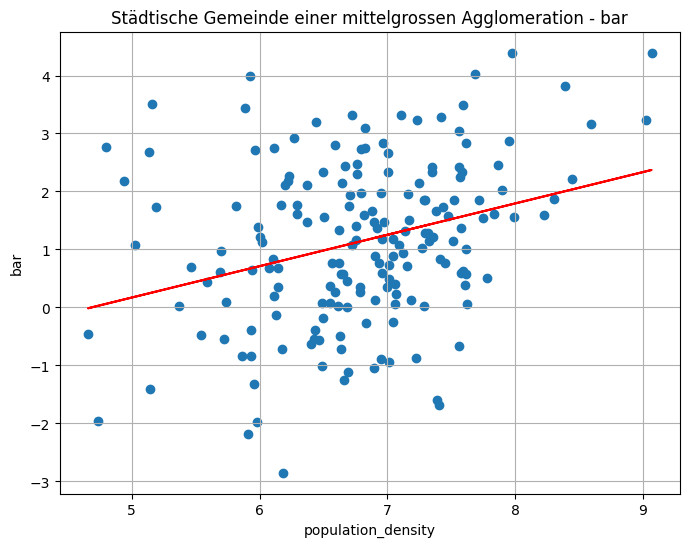

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


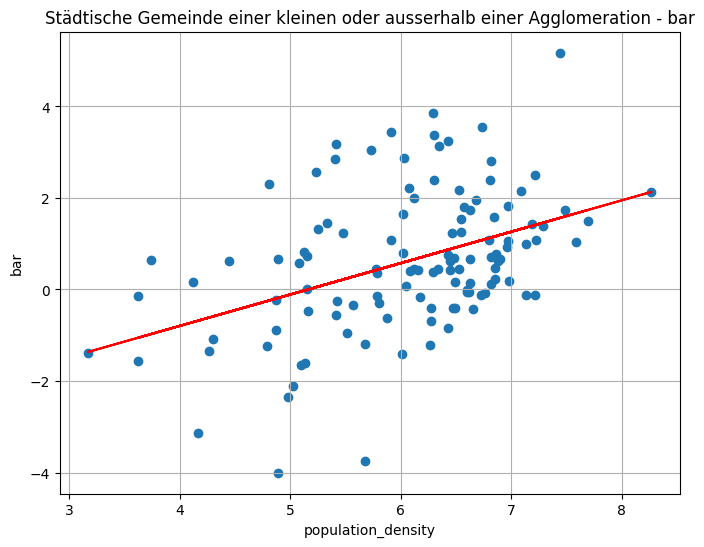

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


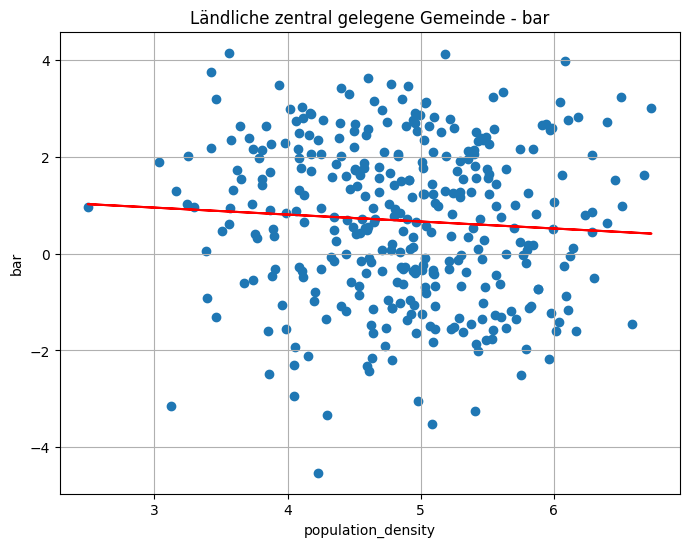

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


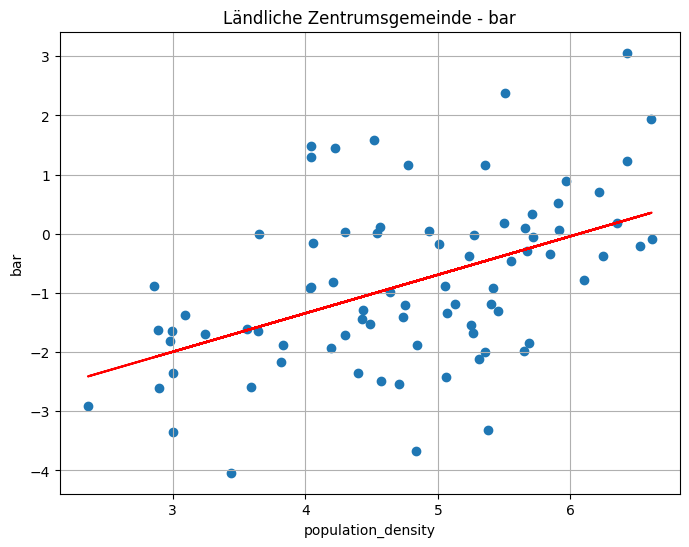

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


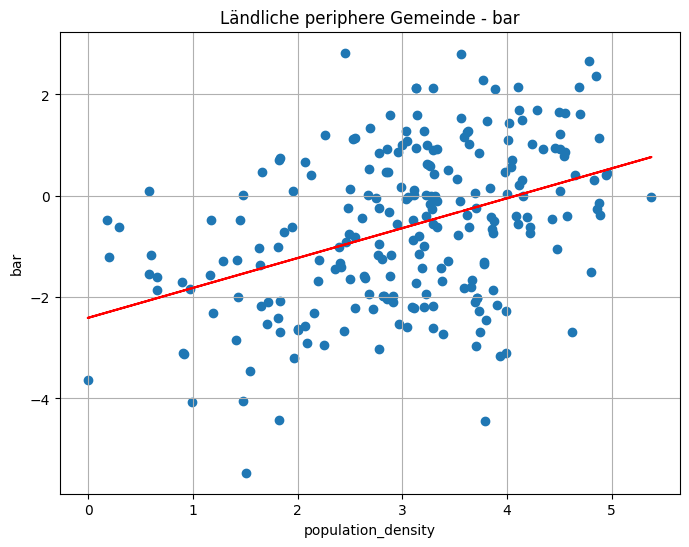

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


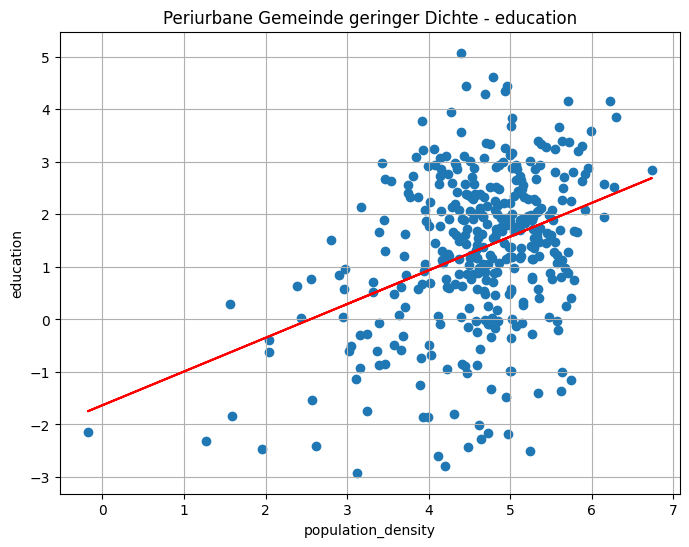

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


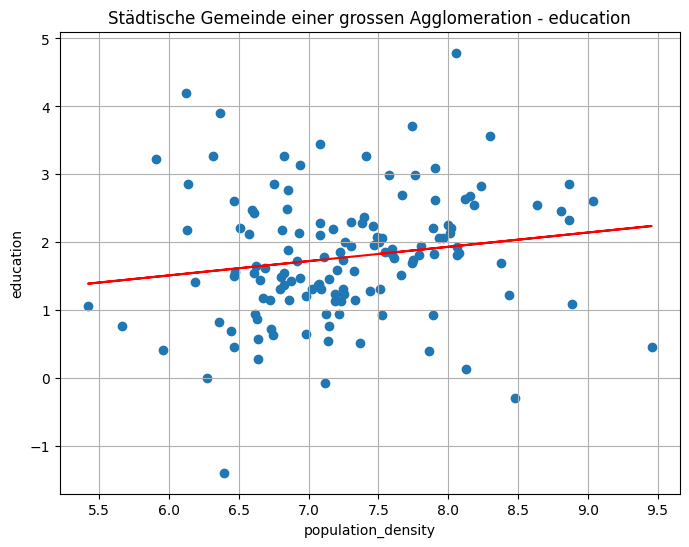

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


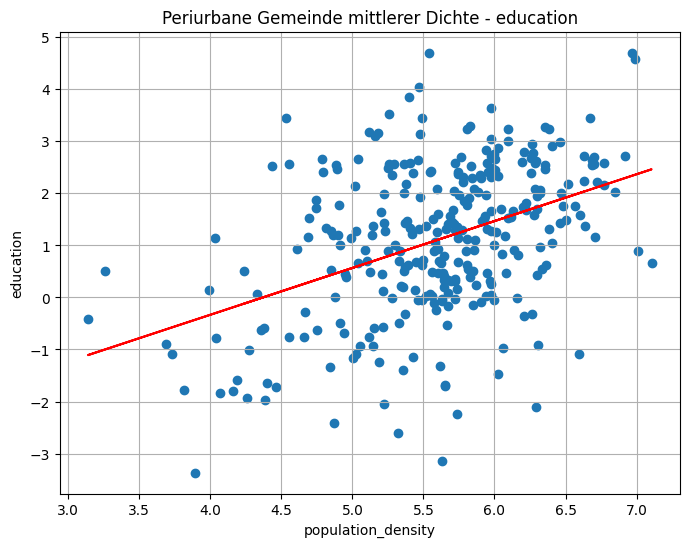

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


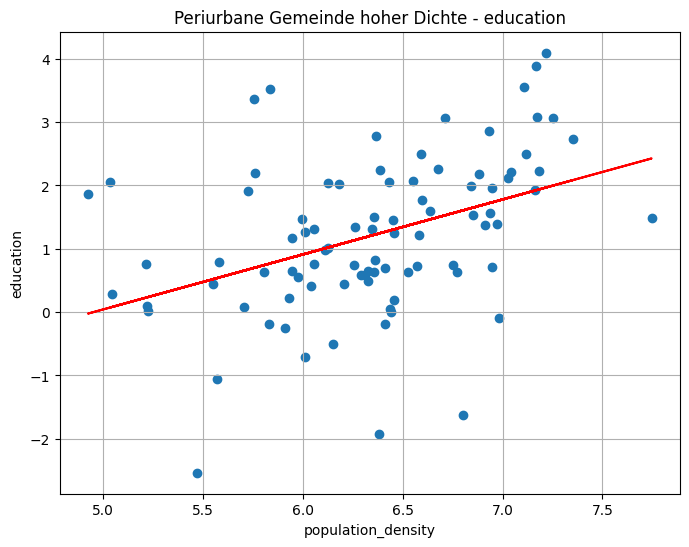

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


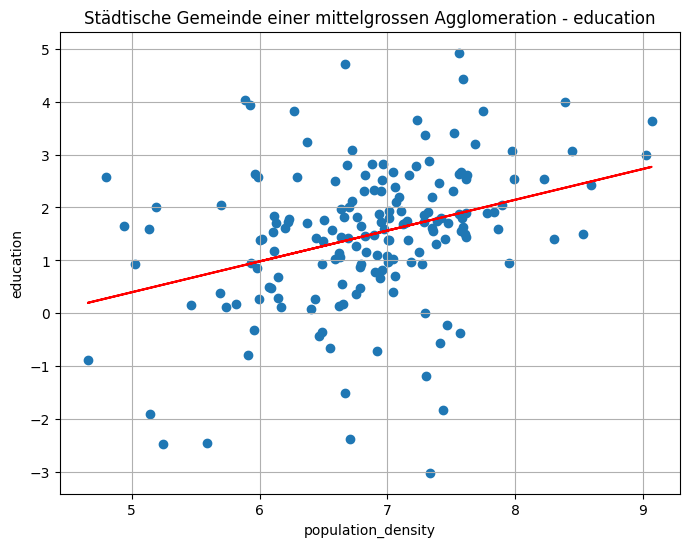

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


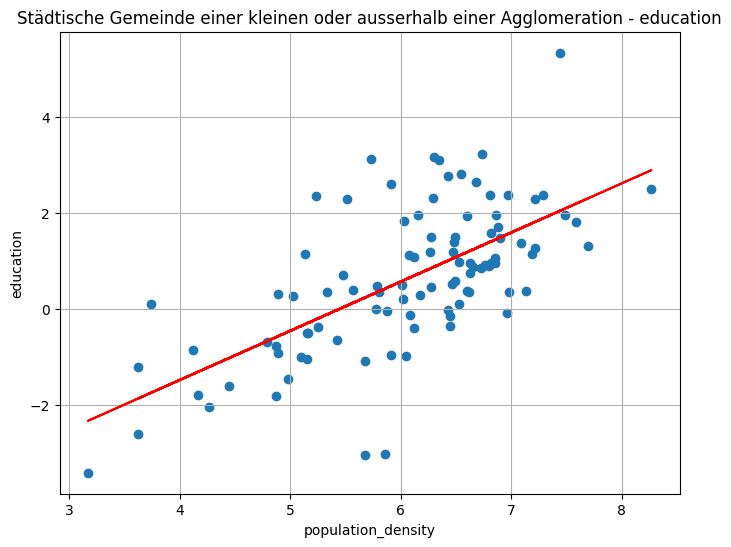

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


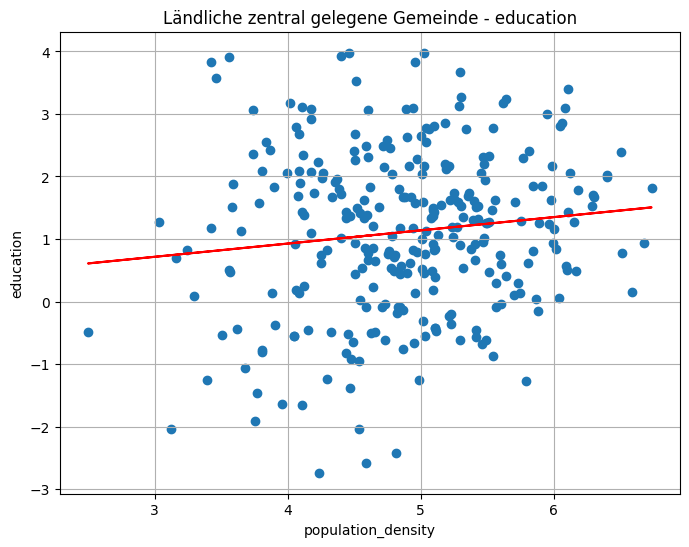

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


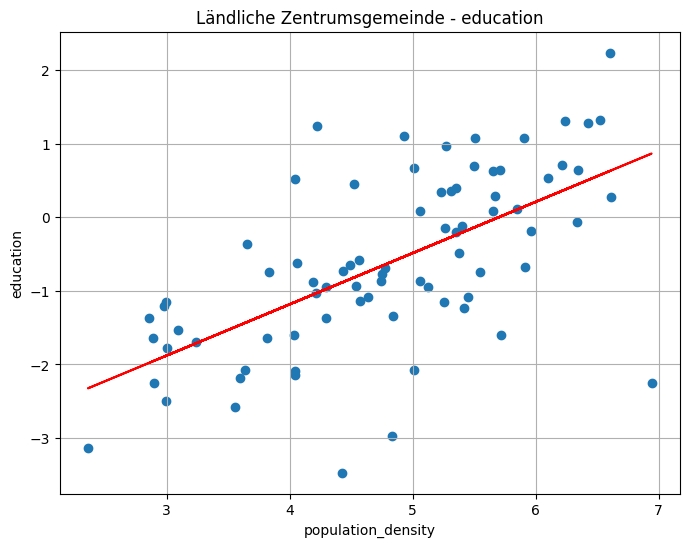

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


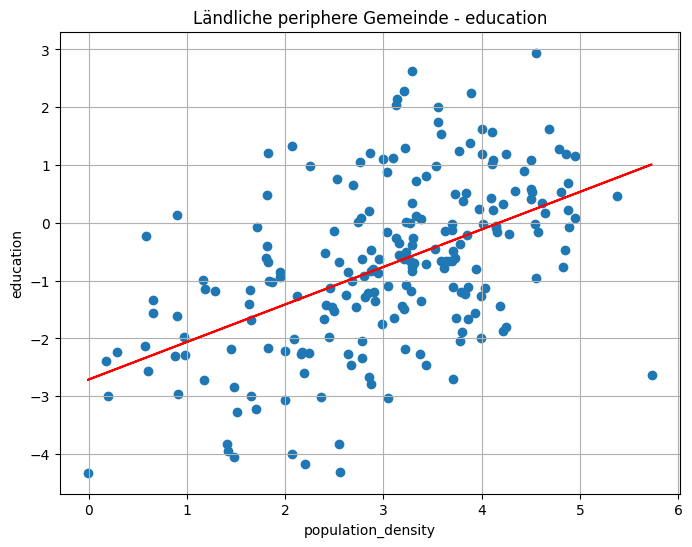

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


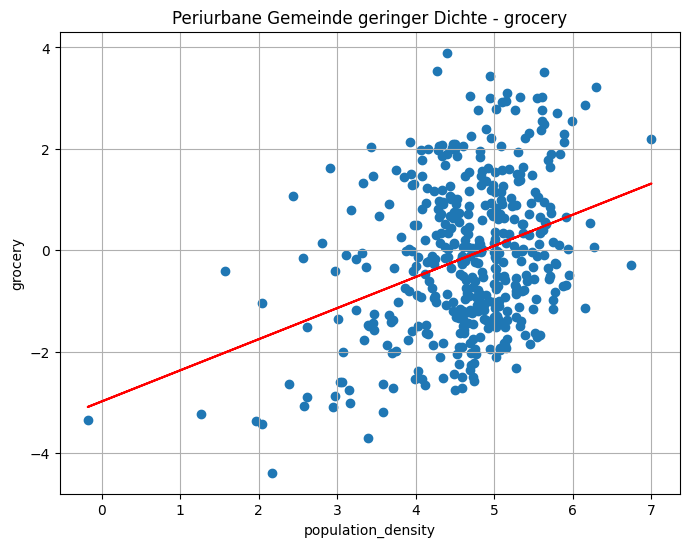

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


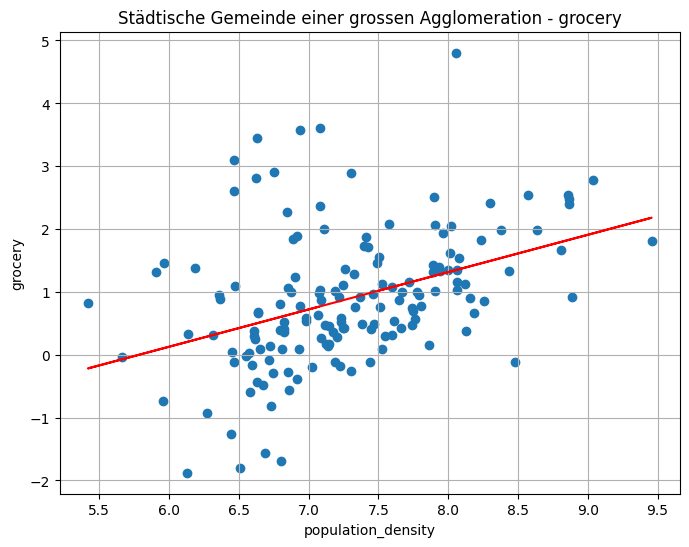

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


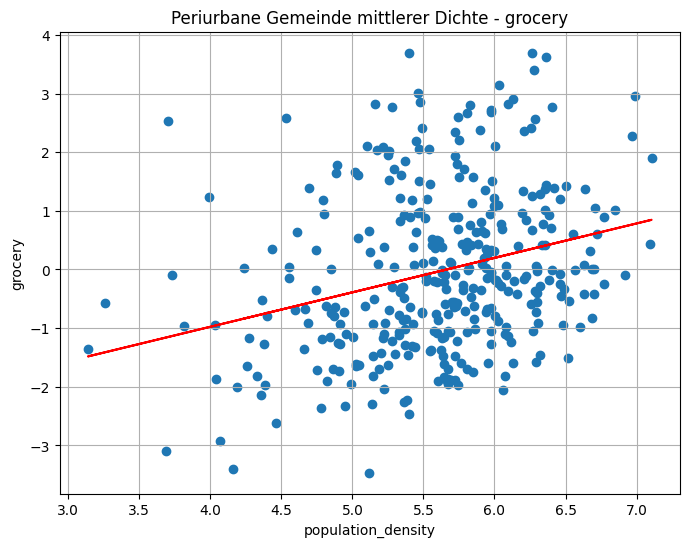

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


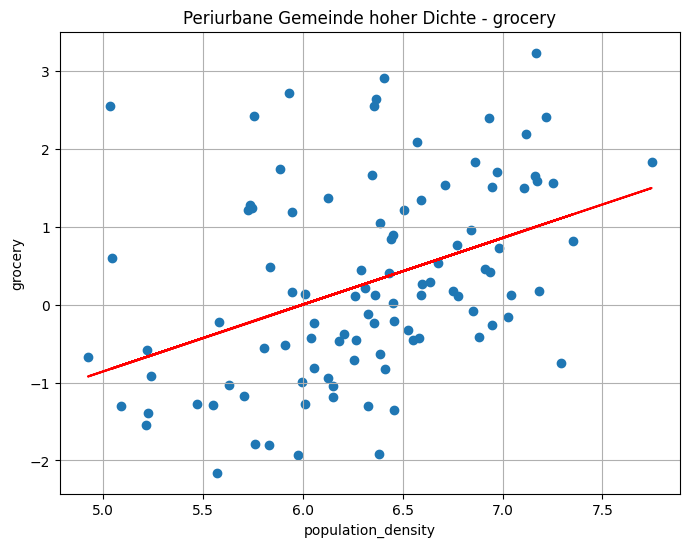

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


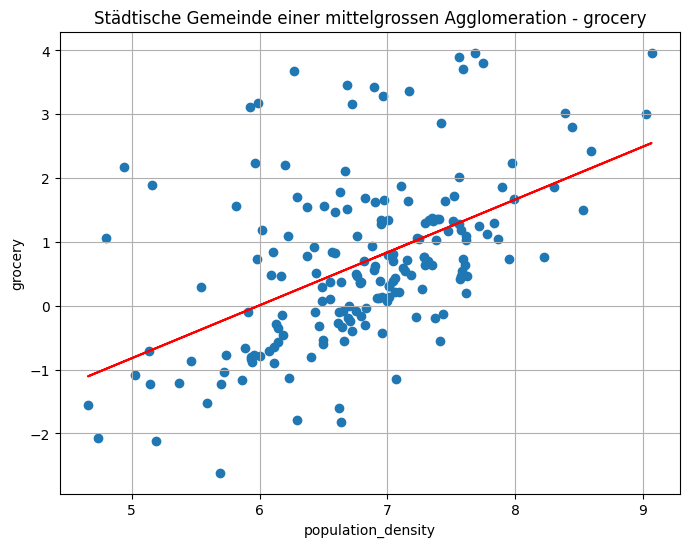

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


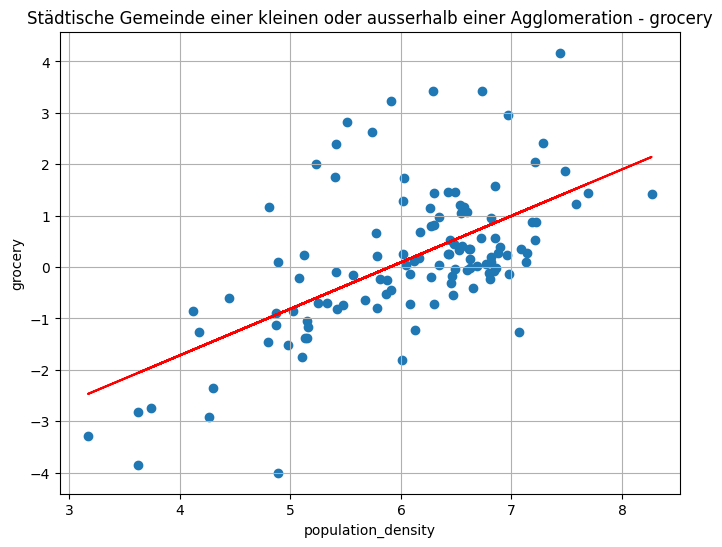

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


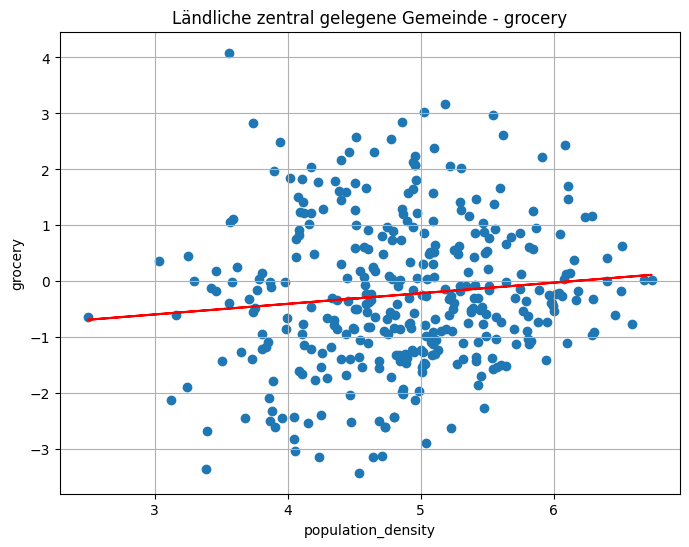

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


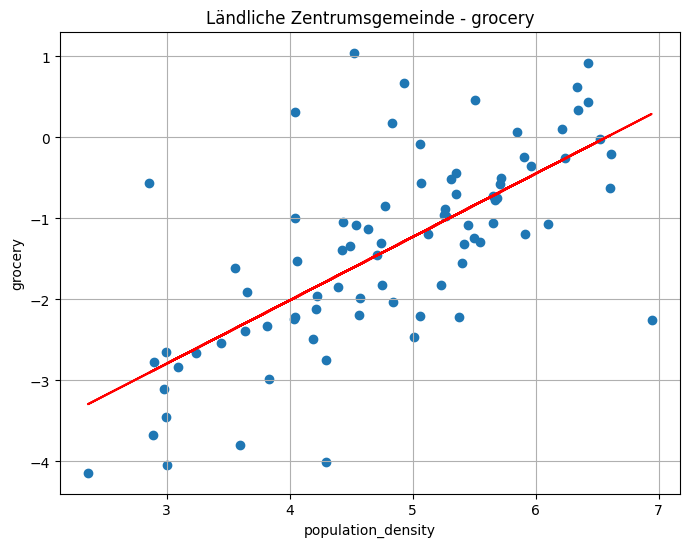

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


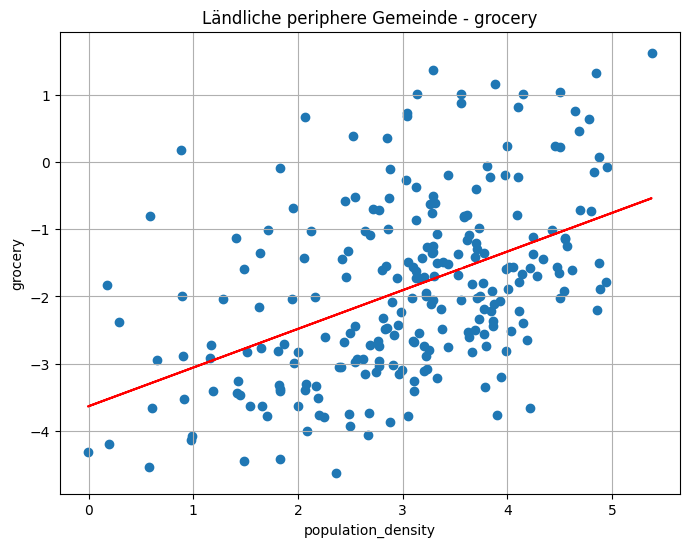

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


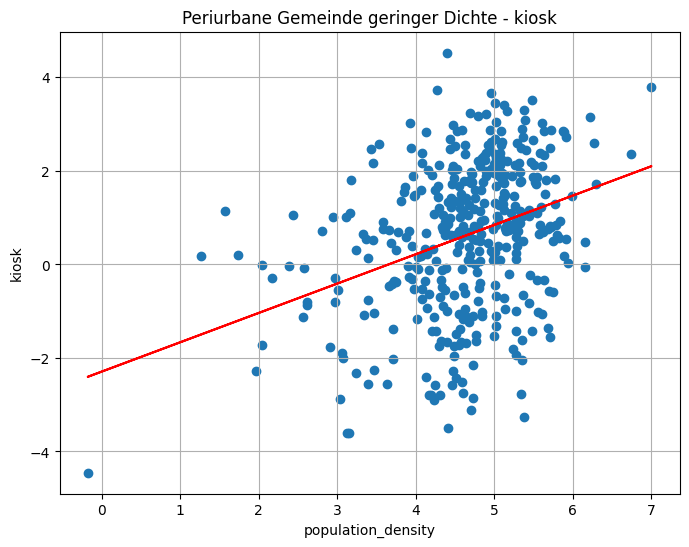

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


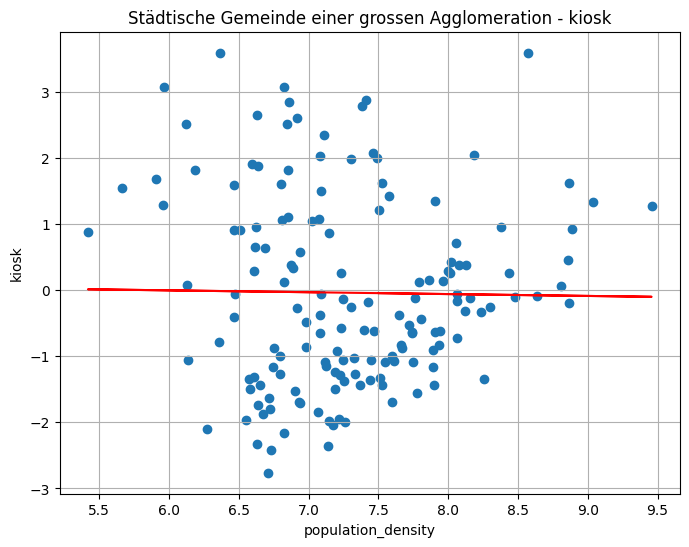

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


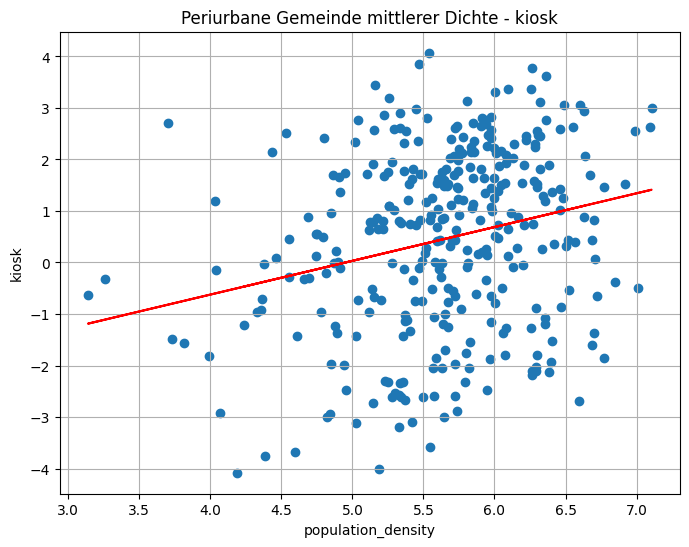

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


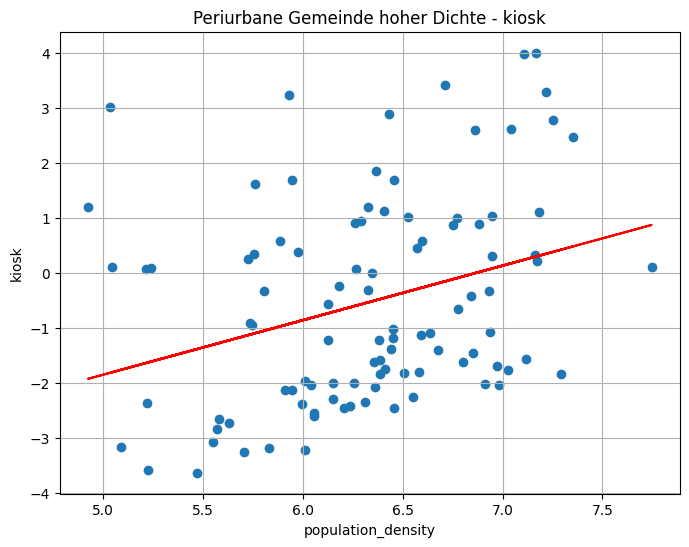

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


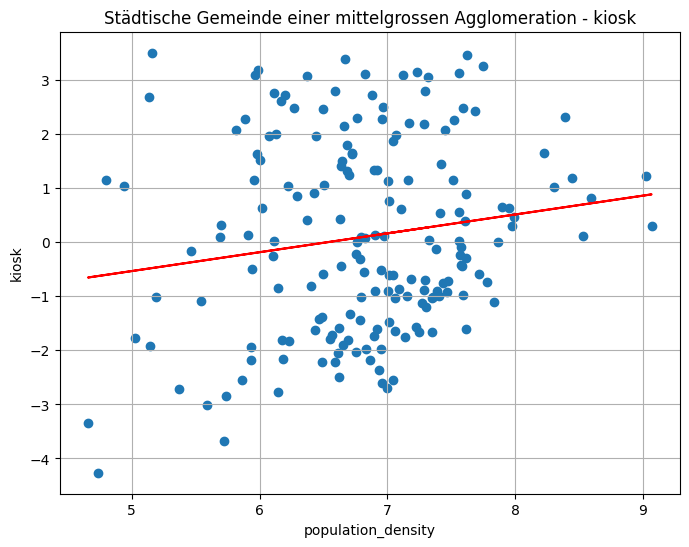

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


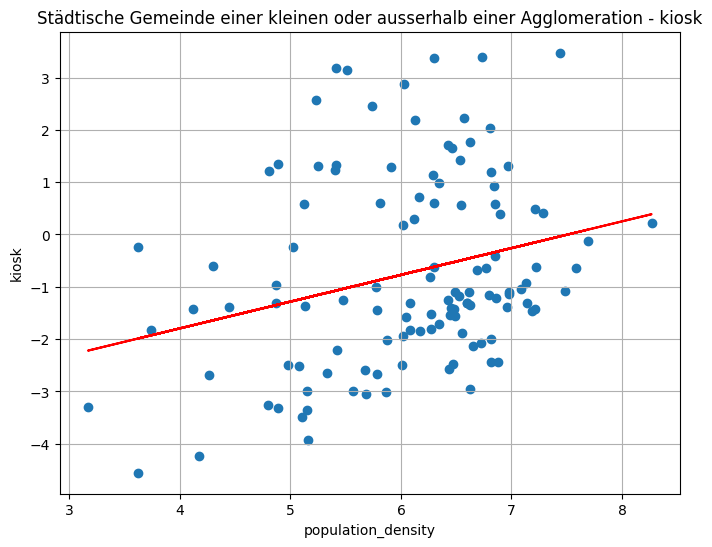

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


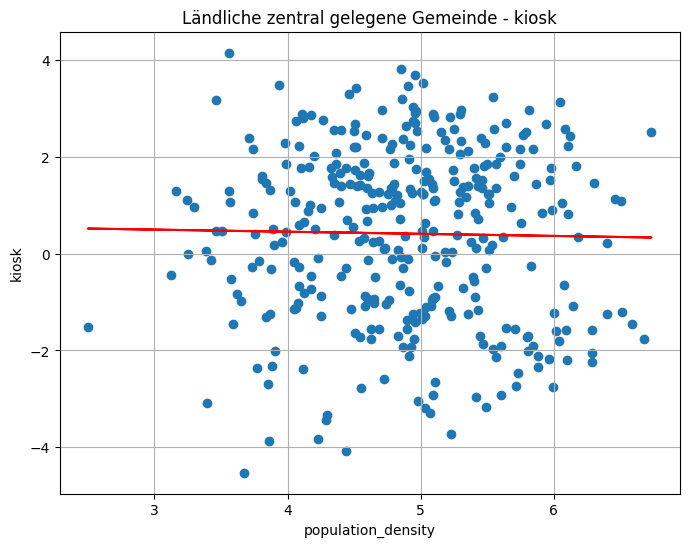

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


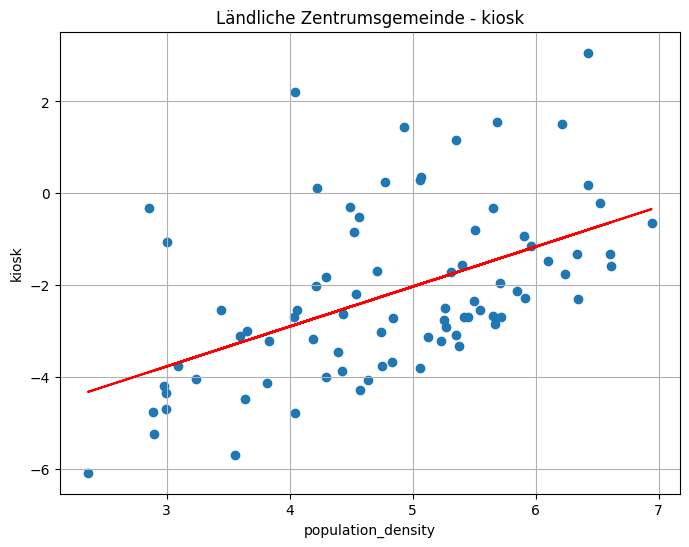

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


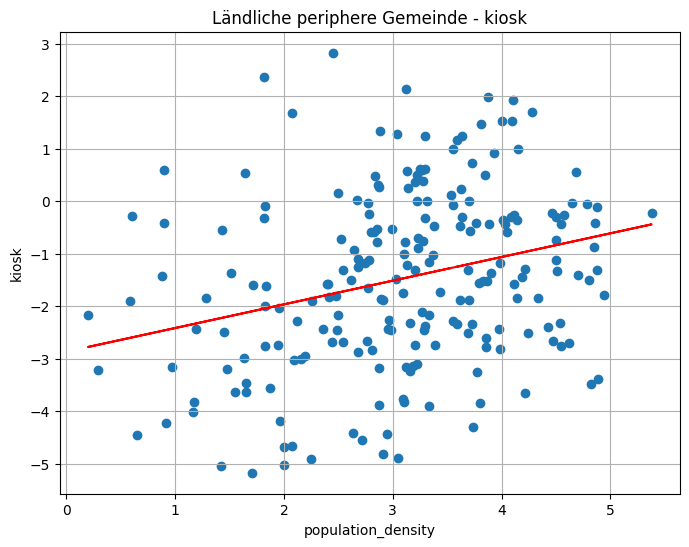

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


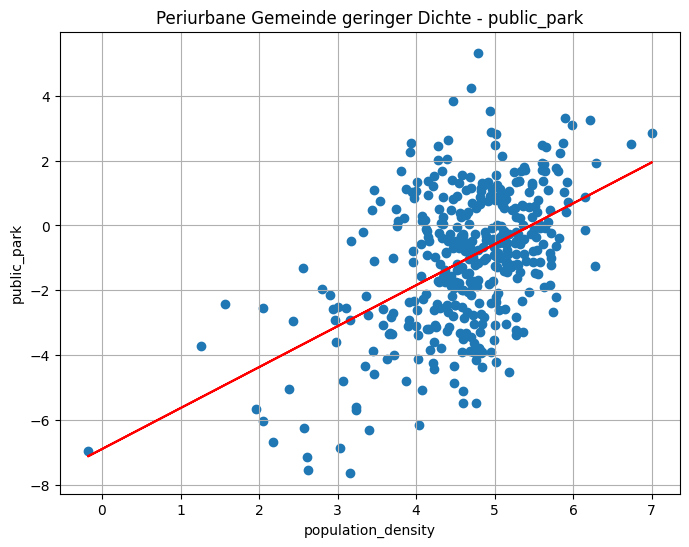

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


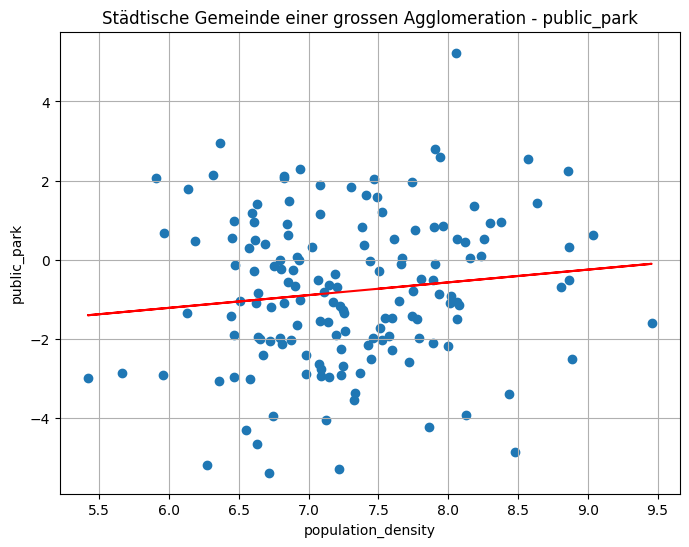

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


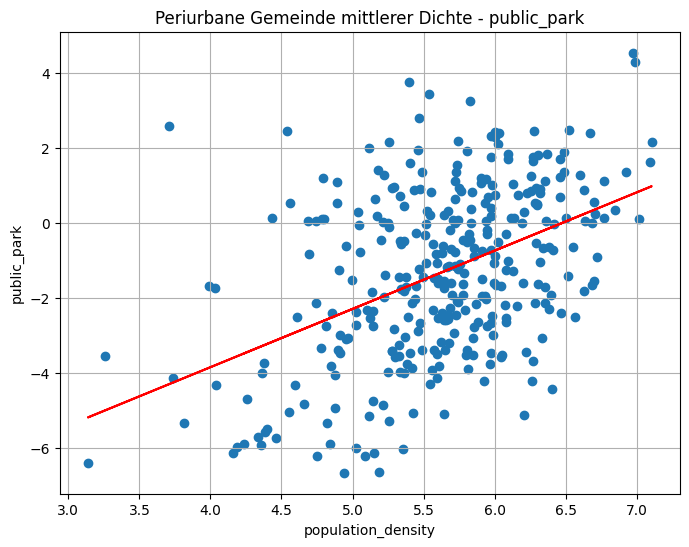

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


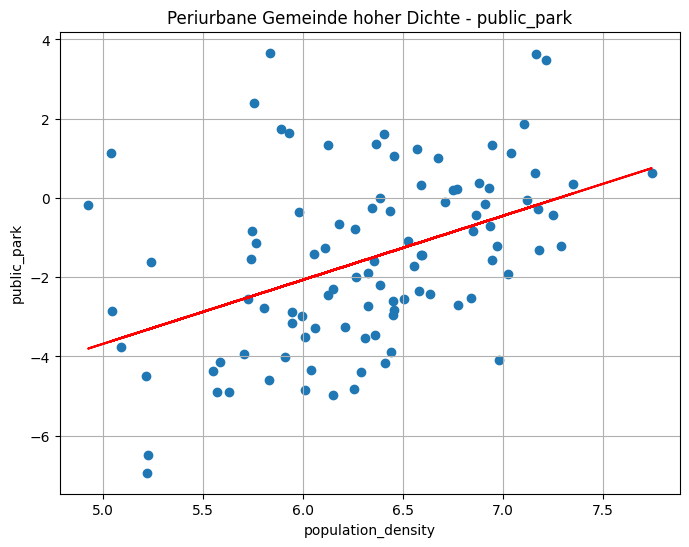

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


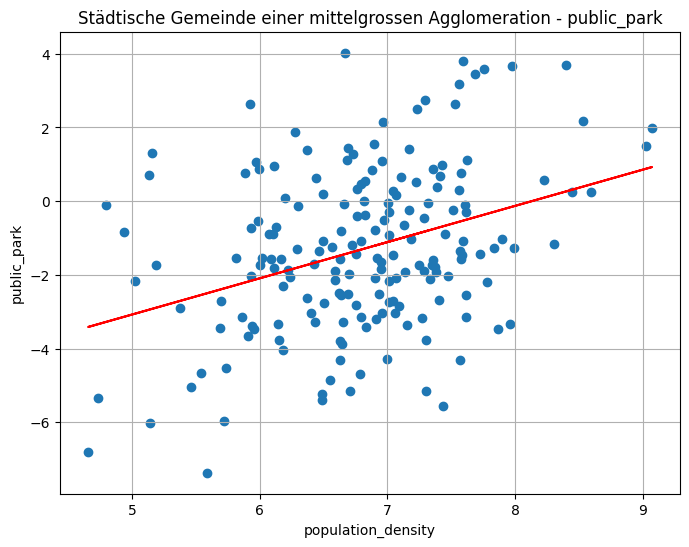

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


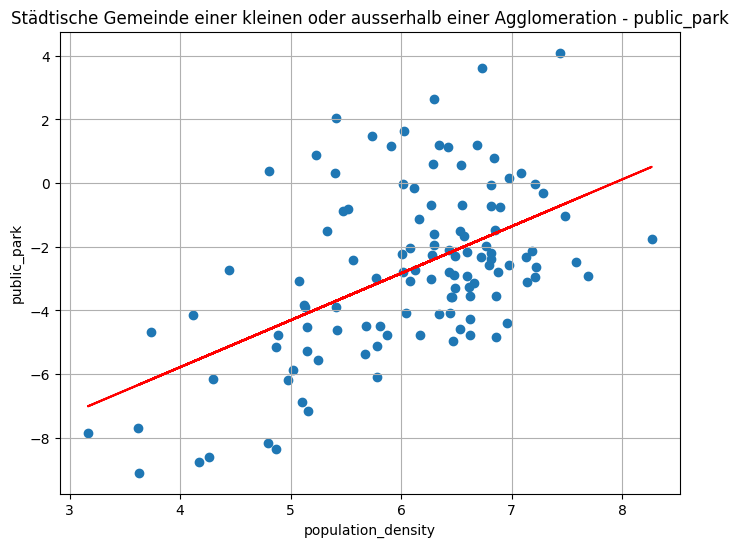

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


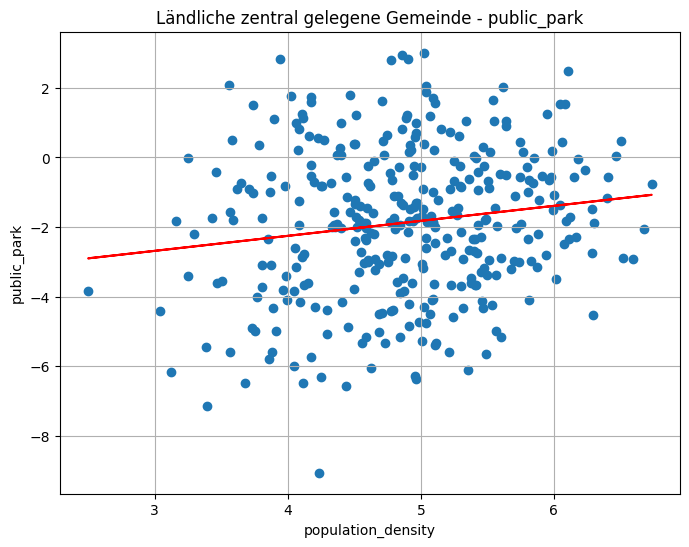

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


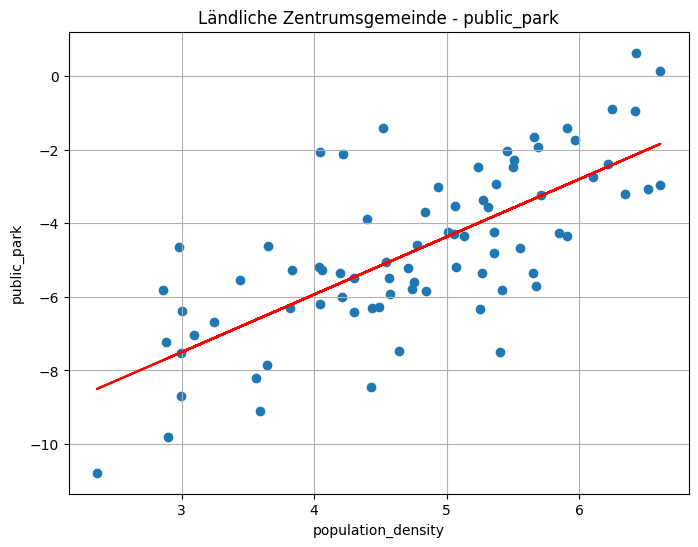

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


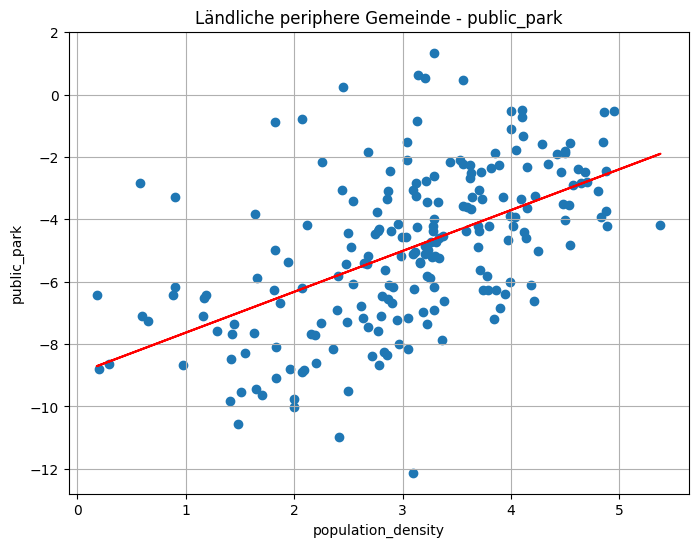

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


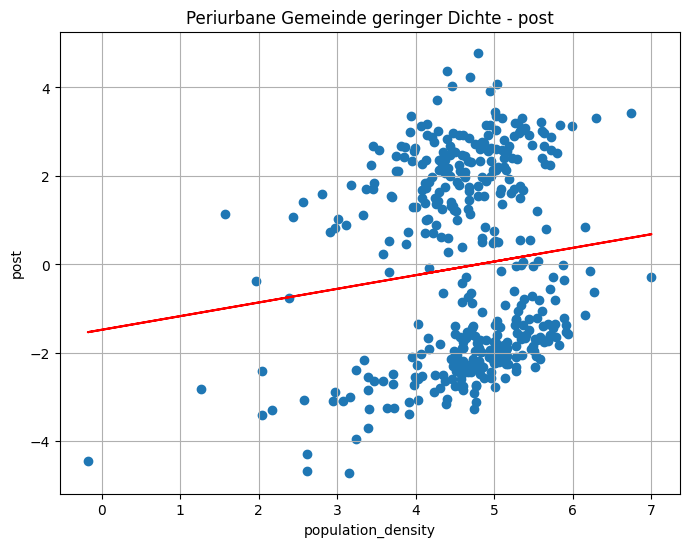

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


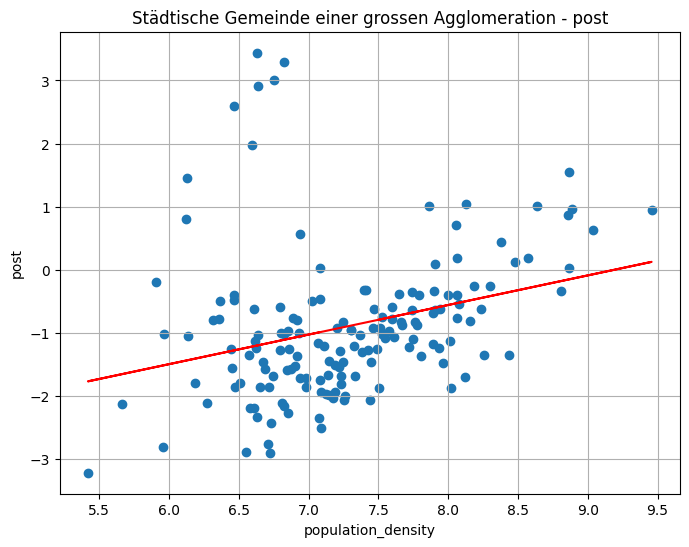

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


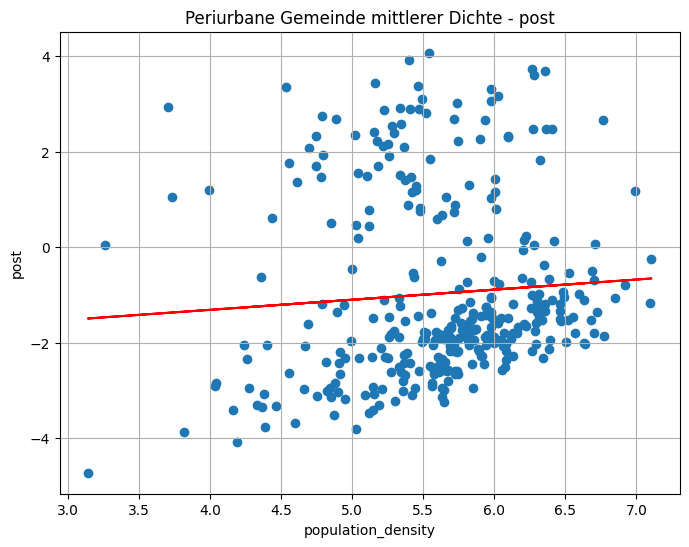

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


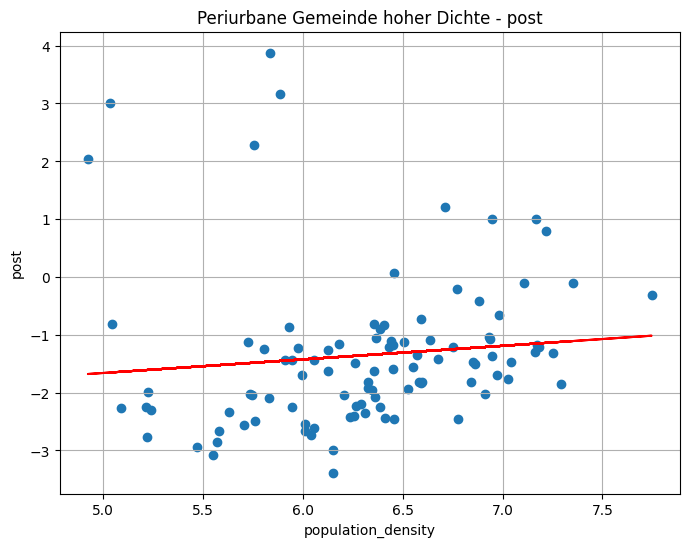

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


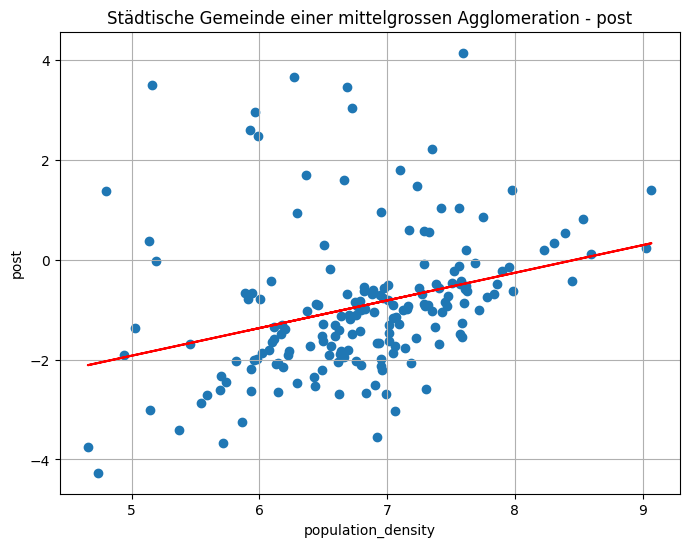

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


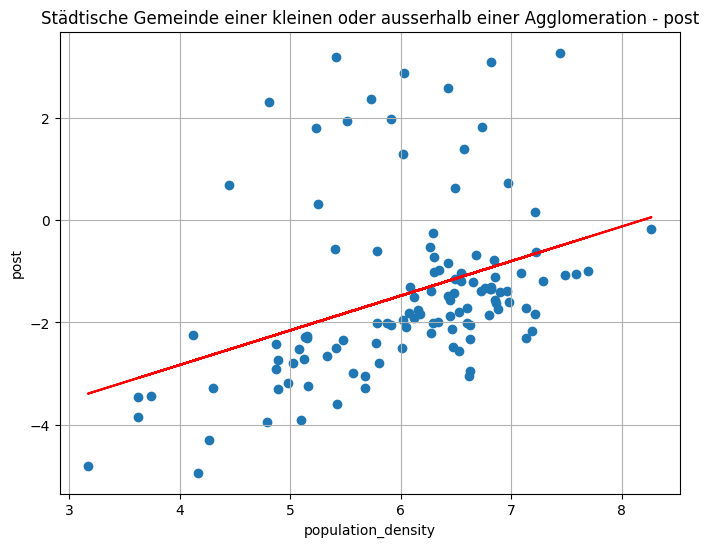

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


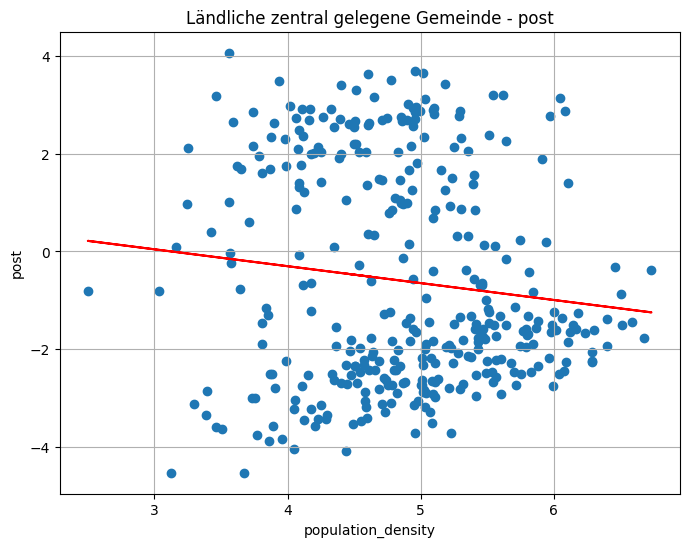

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


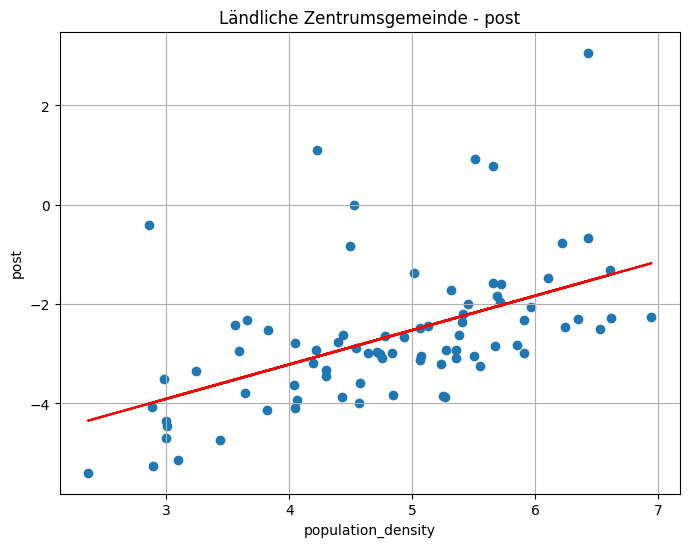

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


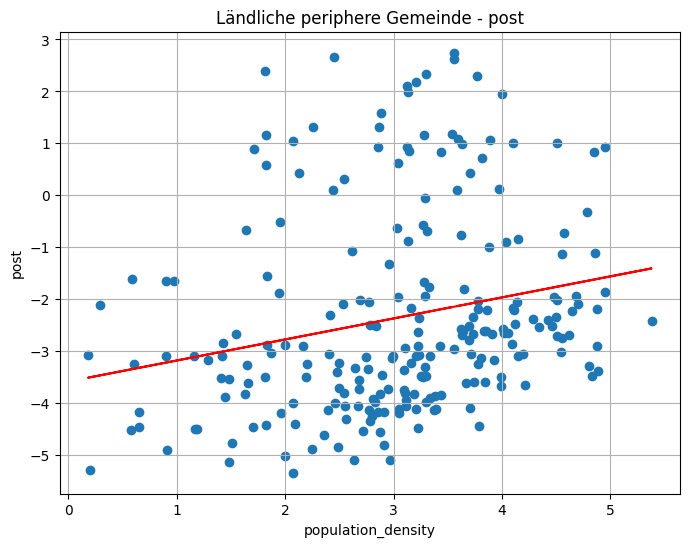

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


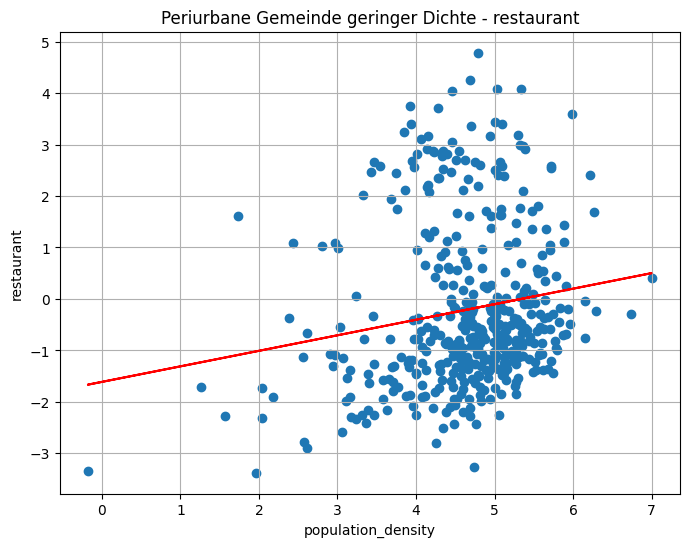

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


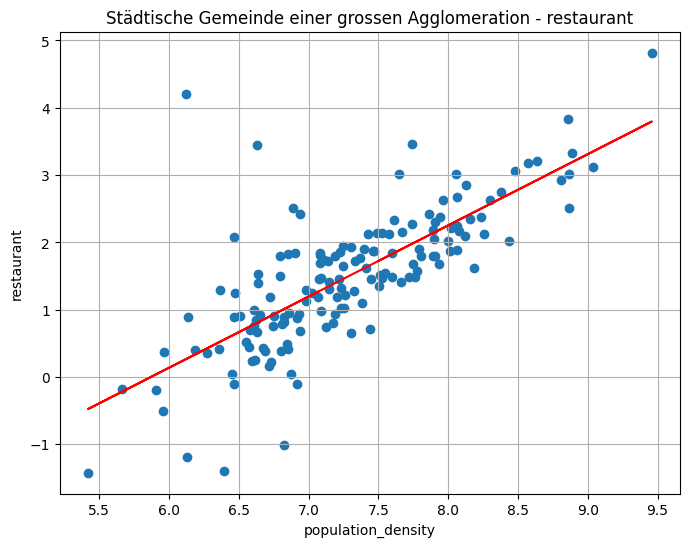

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


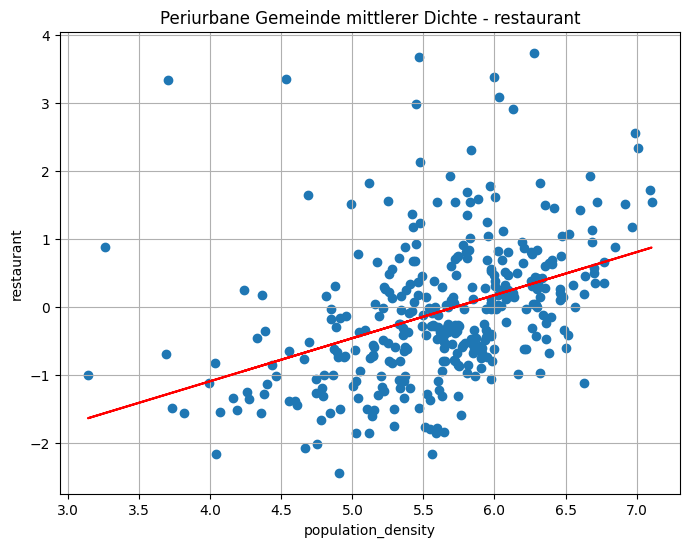

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


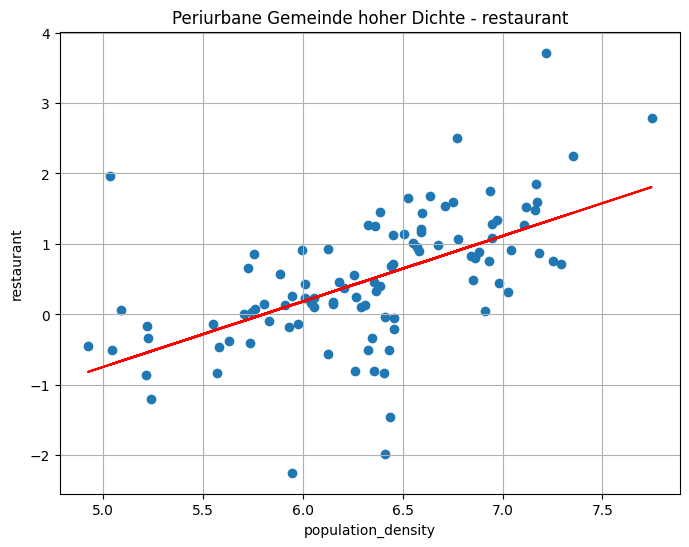

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


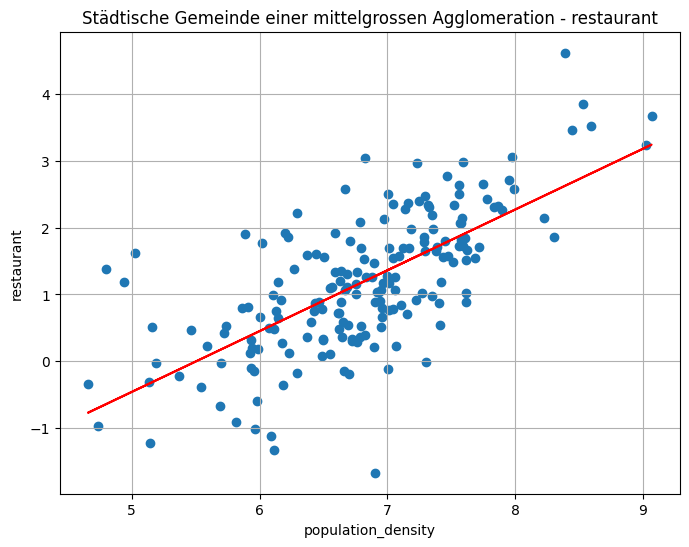

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


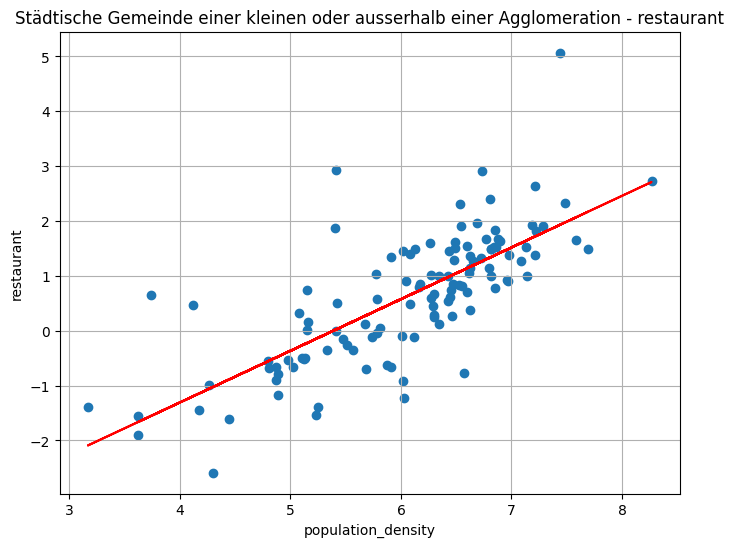

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


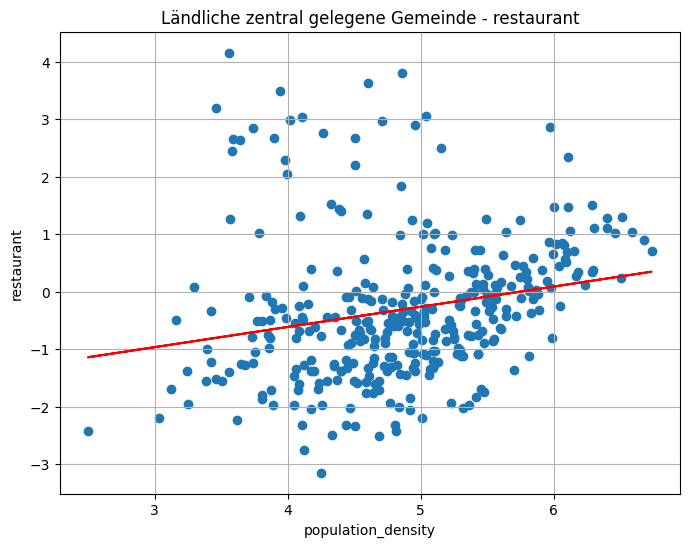

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


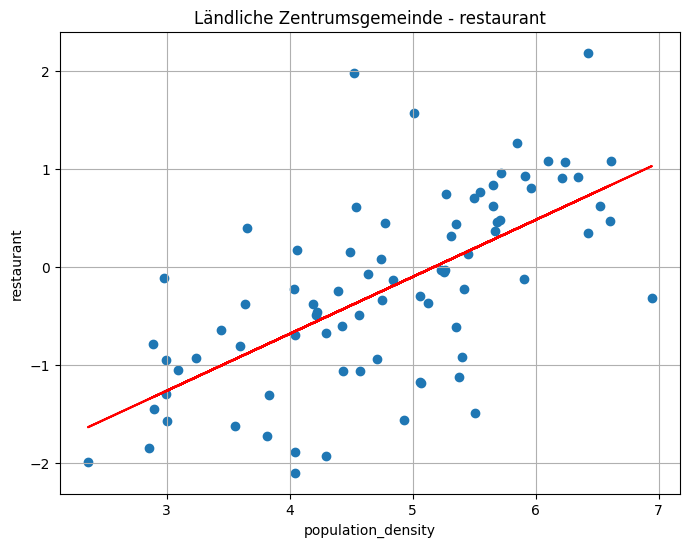

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


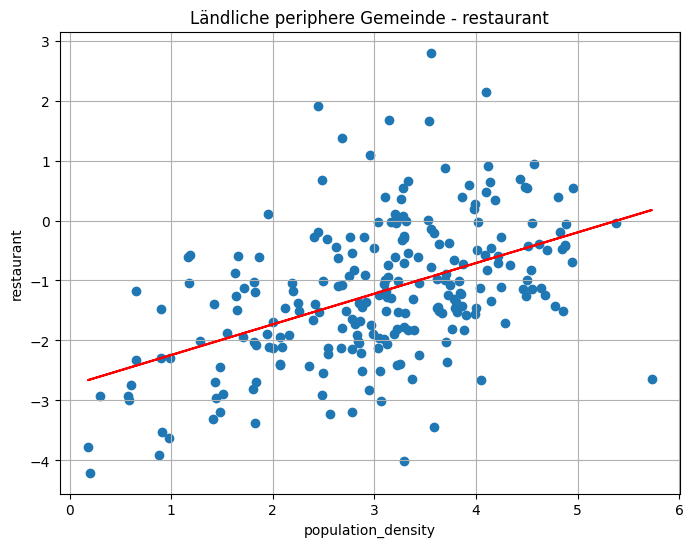

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


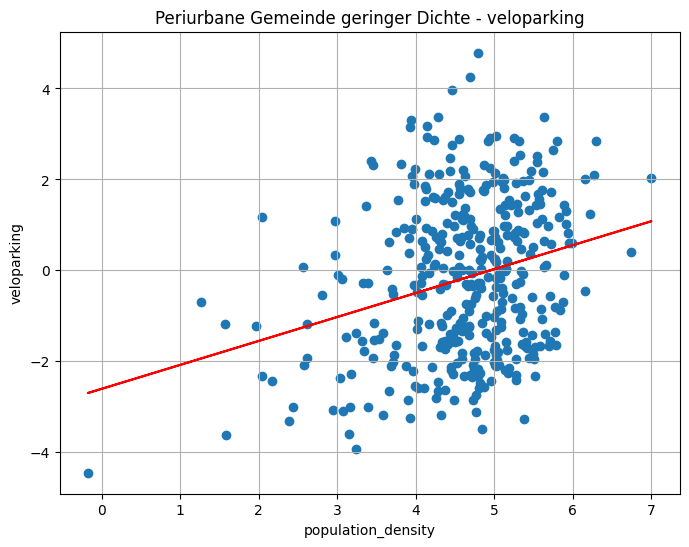

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


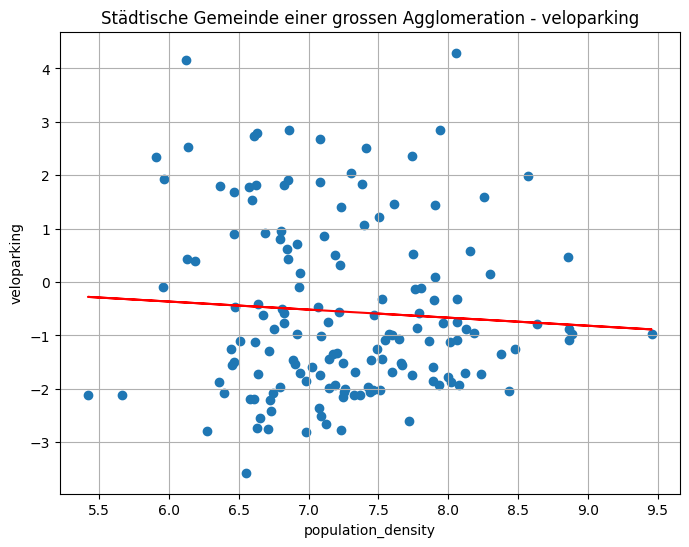

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


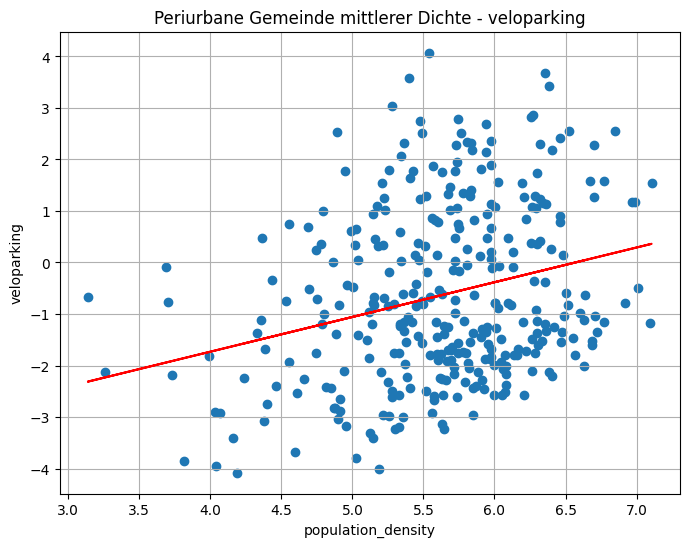

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


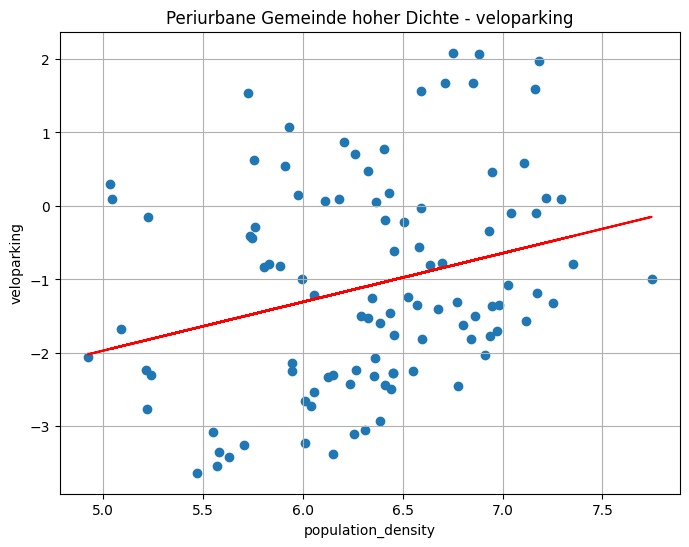

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


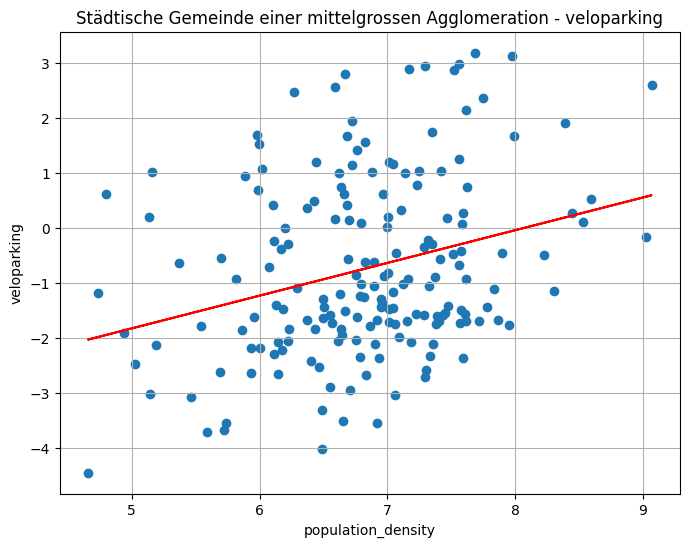

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


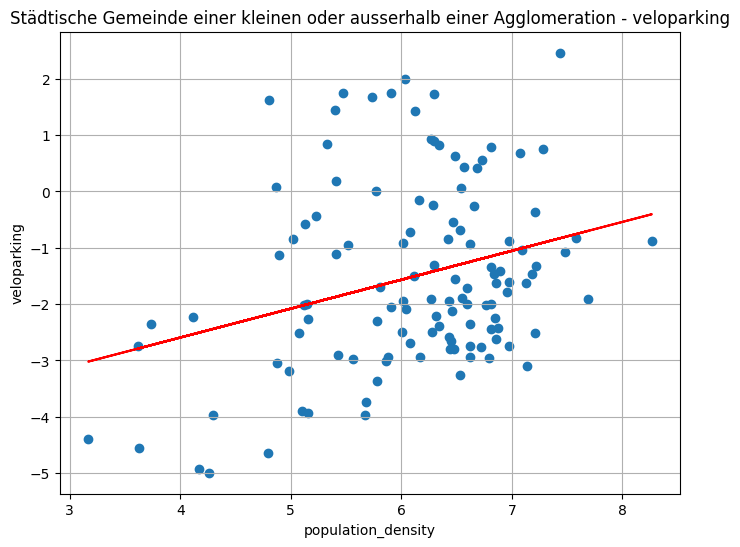

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


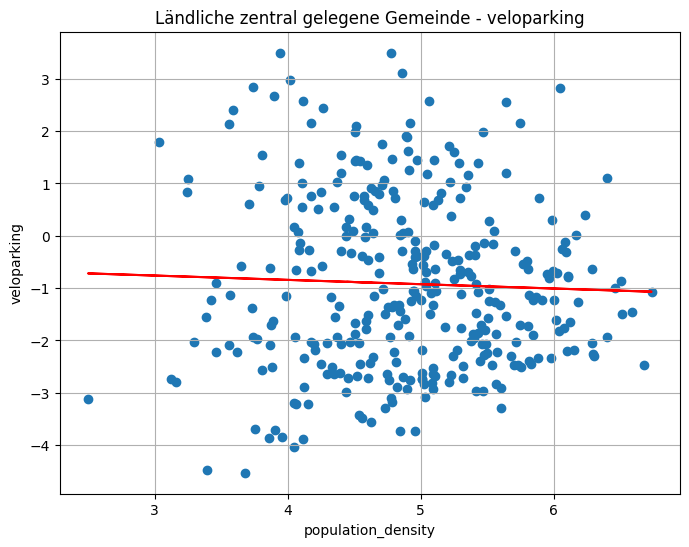

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


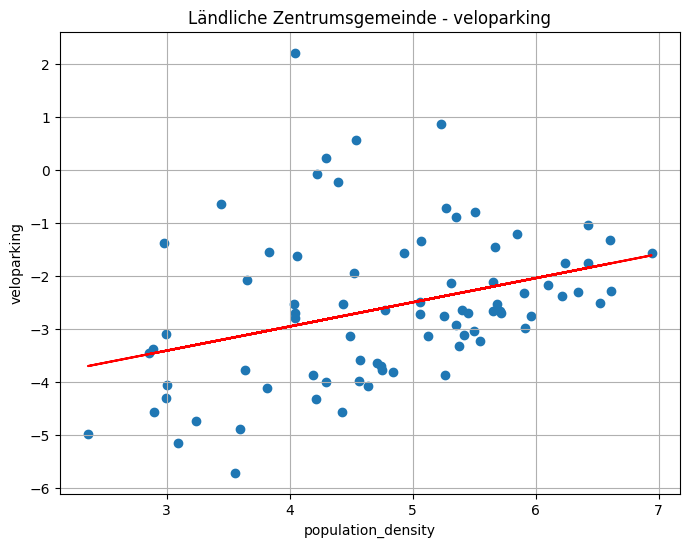

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


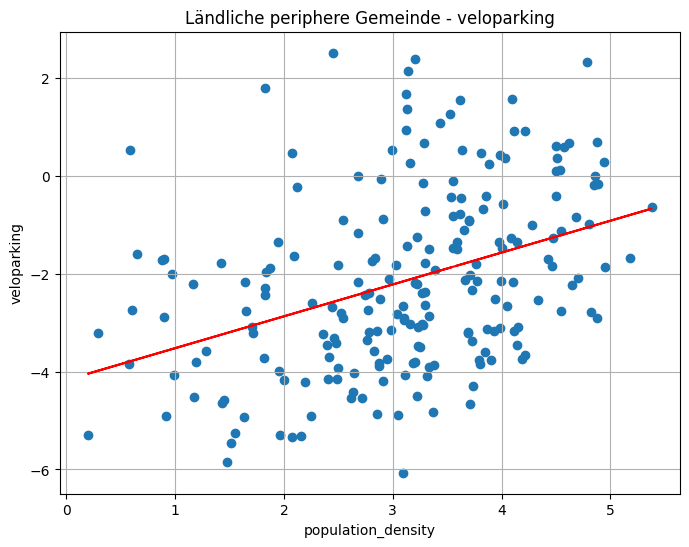

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


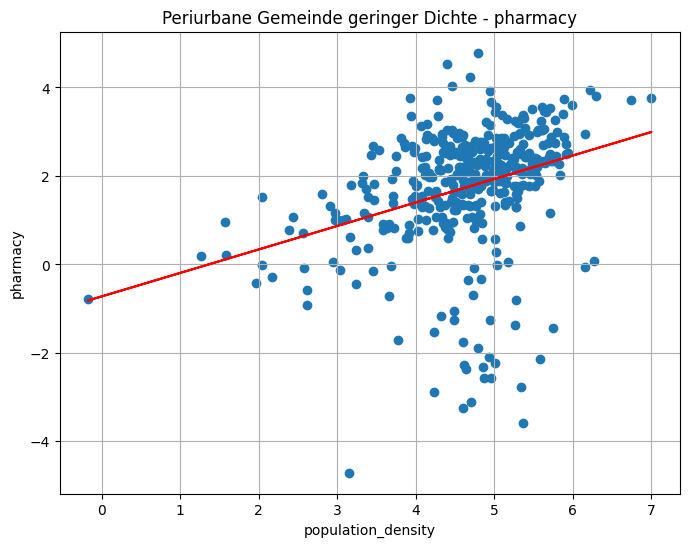

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


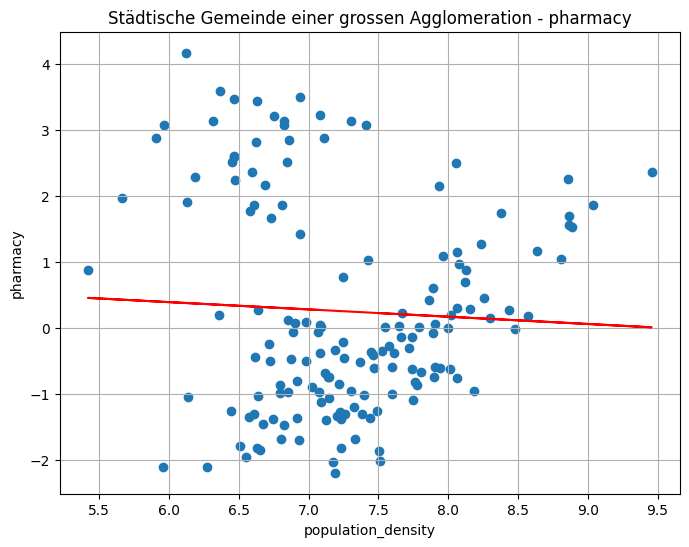

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


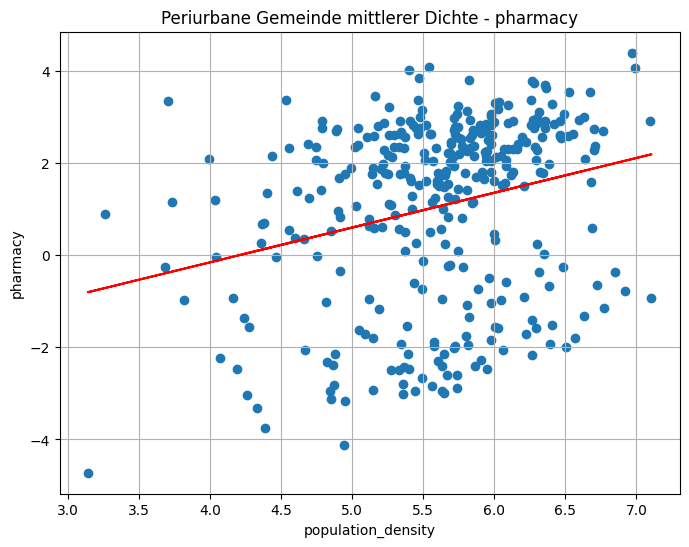

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


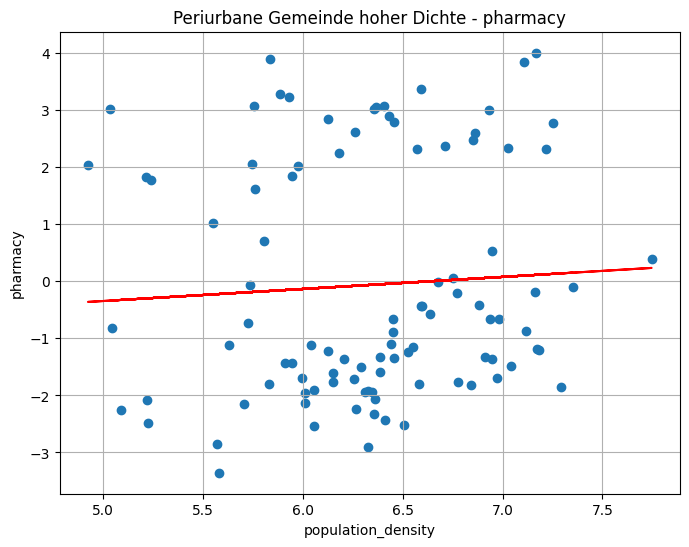

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


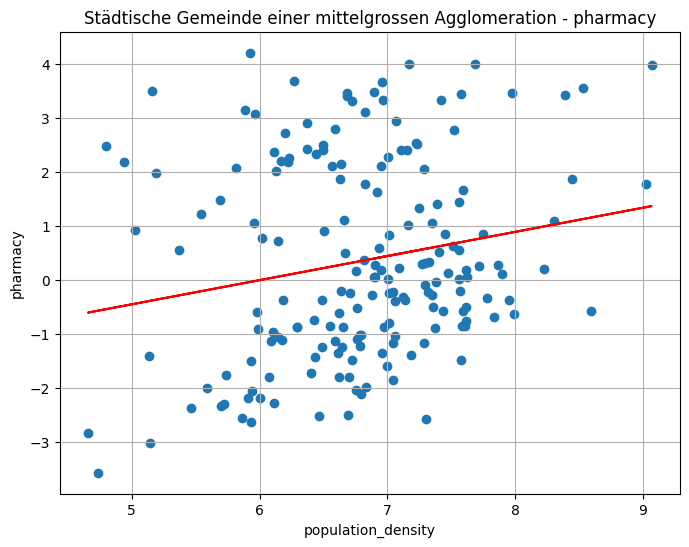

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


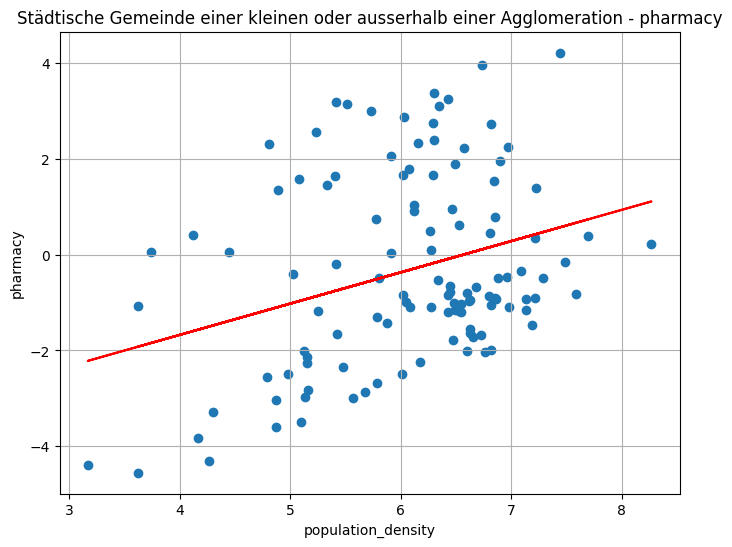

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


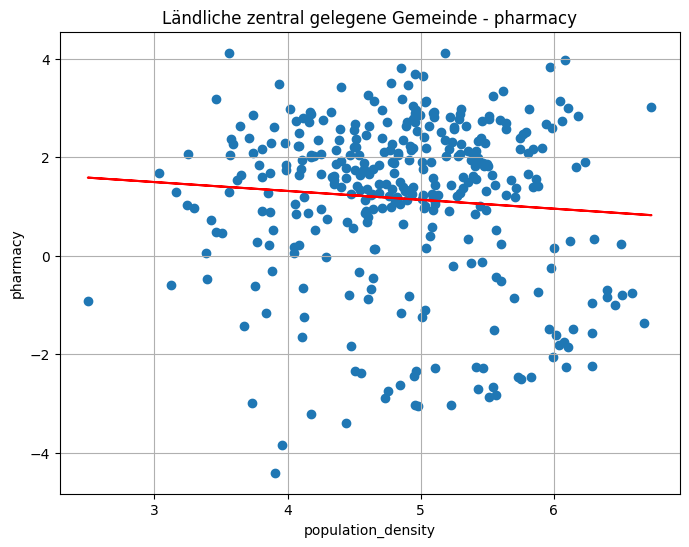

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


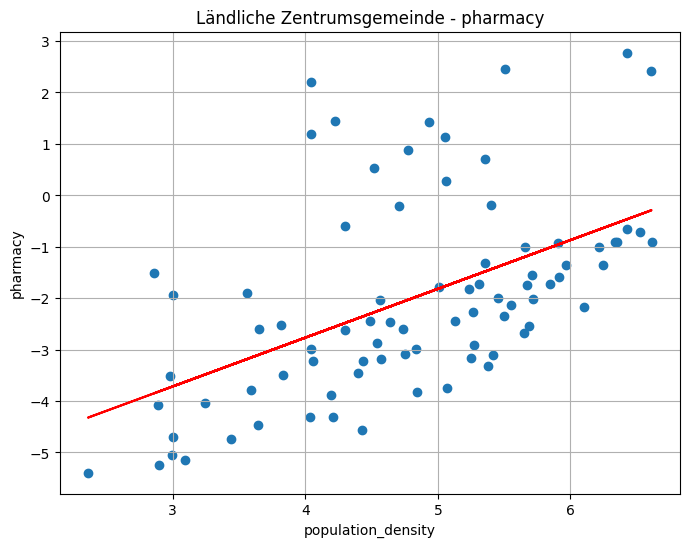

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


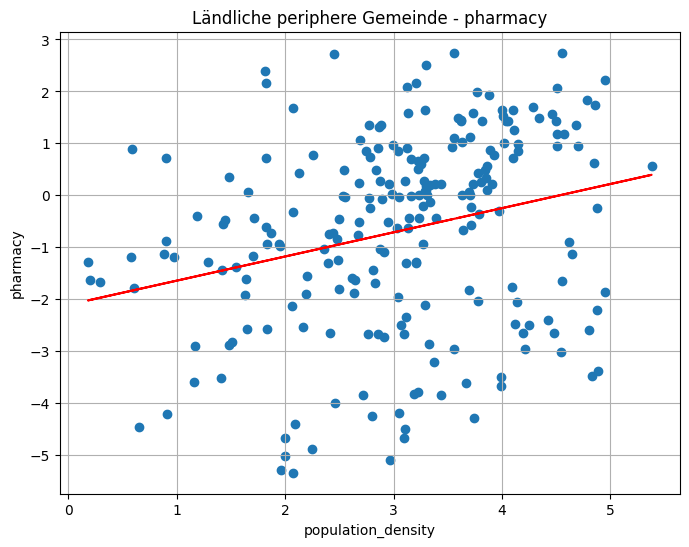

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


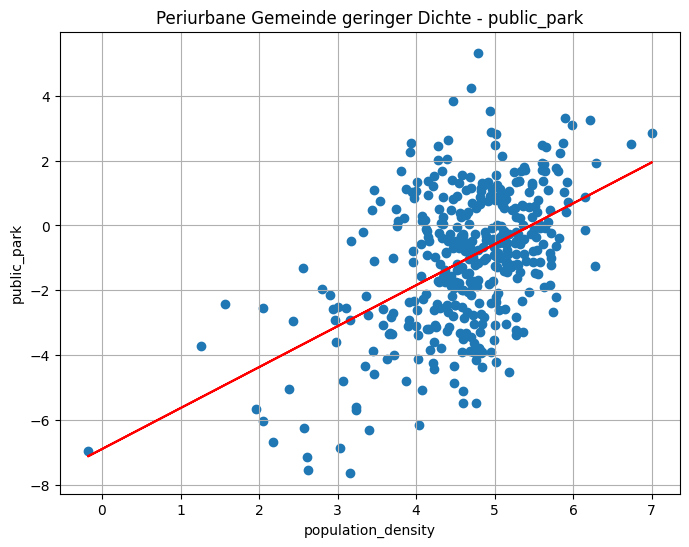

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


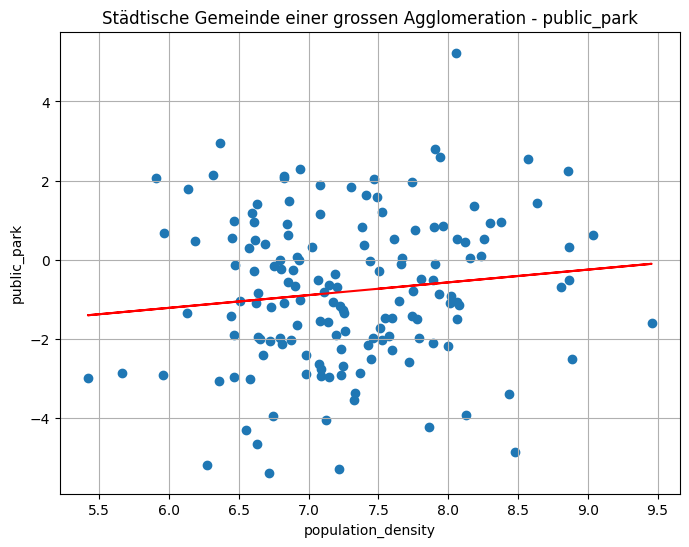

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


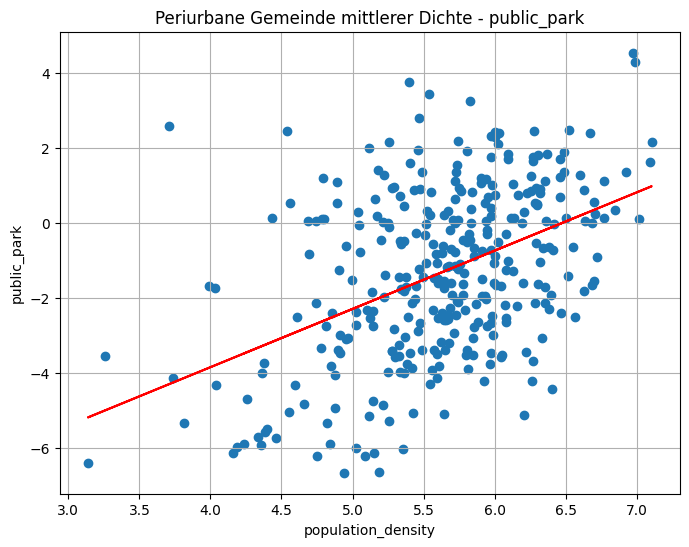

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


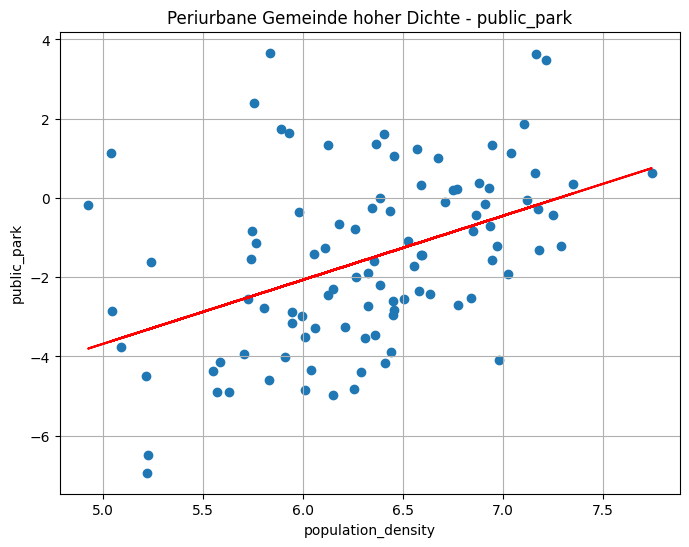

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


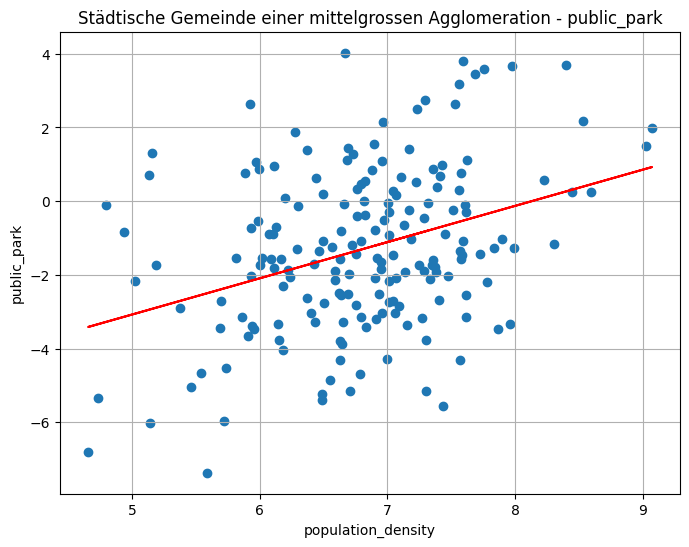

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


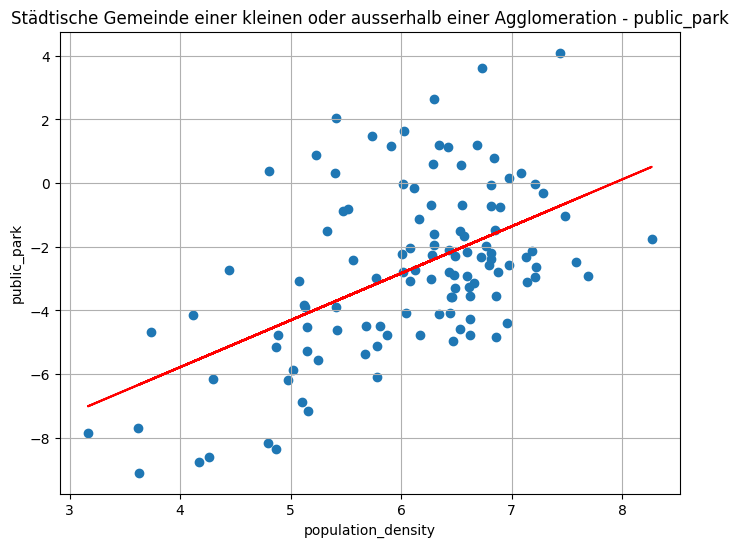

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


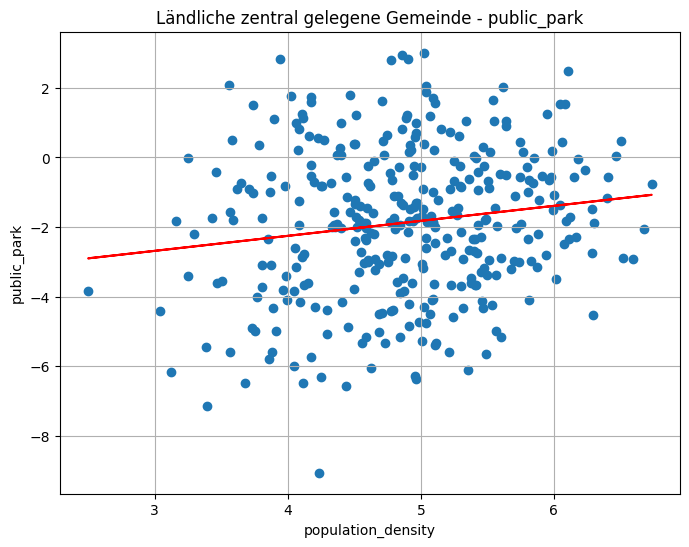

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


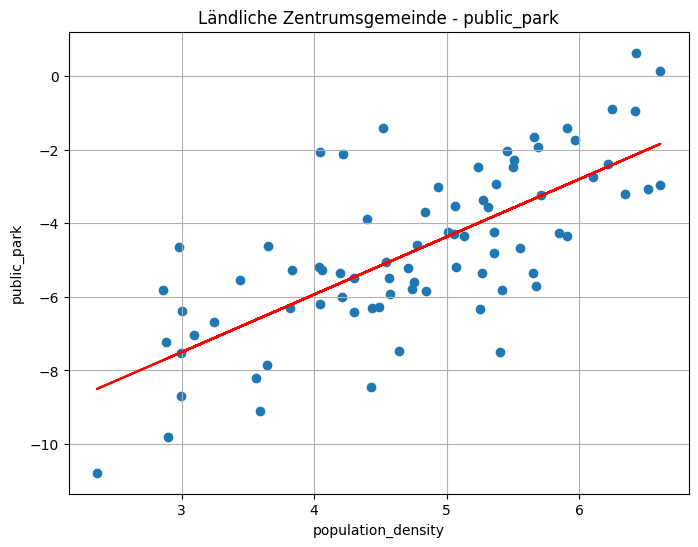

<ipython-input-90-0b868b8bec2f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({"Variable": filename,


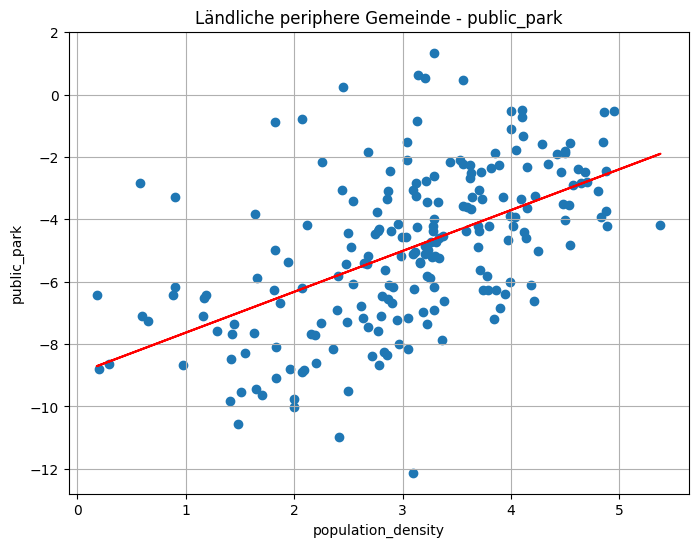

       Variable Code     Slope
0        bakery   23  0.430475
1        bakery   11  0.245816
2        bakery   22  0.654411
3        bakery   21  0.744493
4        bakery   12  0.701324
..          ...  ...       ...
94  public_park   12  0.983622
95  public_park   13  1.475479
96  public_park   32  0.430905
97  public_park   31  1.568477
98  public_park   33  1.310573

[99 rows x 3 columns]


In [90]:
code_to_label = dict(zip(gemeinde['Code'], gemeinde['Label']))

# Prepare the final results dataframe
final_results = pd.DataFrame(columns=["Variable", "Code", "Slope"])


for filename in file_names:
    for code in muns['Gemeindetypologie9'].unique():
        temp_df = muns[muns['Gemeindetypologie9'] == code].copy()

        # Filter out rows with zero or negative values in population_density or current variable column
        temp_df = temp_df[(temp_df['population_density'] > 0) & (temp_df[filename] > 0)]

        # Now it's safe to take logarithm
        X = np.log(temp_df['population_density']).values.reshape(-1,1)
        y = np.log(temp_df[filename]).values.reshape(-1,1)

        model = LinearRegression().fit(X, y)

        # Append results to the dataframe
        final_results = final_results.append({"Variable": filename,
                                              "Code": code,
                                              "Slope": model.coef_[0][0]}, ignore_index=True)

        # Scatterplot
        plt.figure(figsize=(8, 6))
        plt.scatter(X, y)
        plt.plot(X, model.predict(X), color='red')
        plt.title(f"{code_to_label.get(code, 'Unknown Code')} - {filename}")
        plt.xlabel("population_density")
        plt.ylabel(filename)
        plt.grid(True)
        plt.show()

print(final_results)